In [1]:
# SARIMAX

In [66]:
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

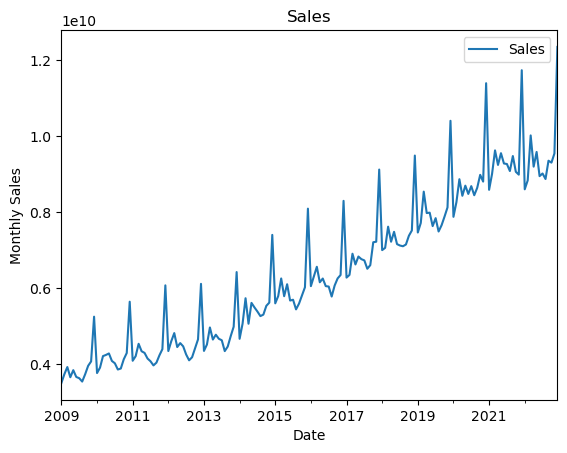

In [67]:
# pandasを使う
df = pd.read_csv("../public/full_monthly_sales.csv", index_col='Month', parse_dates=True)
df.plot()
plt.title('Sales')
plt.ylabel('Monthly Sales')
plt.xlabel('Date')
plt.show()

In [68]:
df_train = df[:132]
df_test = df[132:168]

# 対数変換
df_log = np.log(df).dropna()
df_log_train = df_log[:132]
df_log_test = df_log[132:168]

In [69]:
# pmdarimaのauto_arima関数を使って、ARIMAモデルを自動構築する。

arima_model = pm.auto_arima(df_log_train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-514.164, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-176.115, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-323.208, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-177.508, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-334.285, Time=0.55 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-506.014, Time=0.48 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-502.082, Time=0.38 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-501.583, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-228.075, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-389.652, Time=0.33 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-513.906, Time=0.38 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-508.481, Time=0.40 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-516.181, Time=0.19 sec
 ARIMA(1,1,2)(0,0,1)[12]

In [70]:
# 予測
##学習データの期間の予測値
sarimax_train_log_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
sarimax_test_log_pred, sarimax_test_log_pred_ci = arima_model.predict(
    n_periods=df_log_test.shape[0], 
    return_conf_int=True
)

sarimax_train_pred = np.exp(sarimax_train_log_pred)
sarimax_test_pred = np.exp(sarimax_test_log_pred)

In [71]:
# 元系列に戻してMAPEを計算
print('MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))

MAPE:
0.03675747575470514


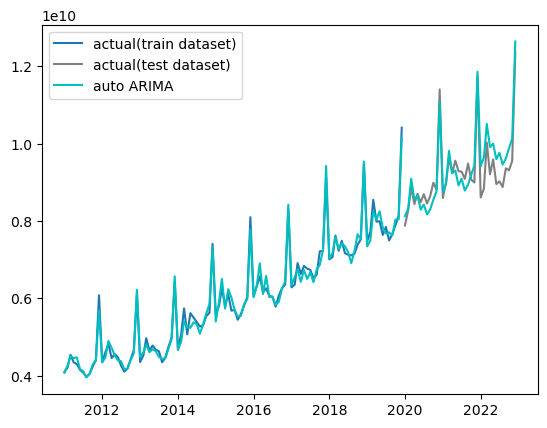

In [72]:
# 元系列のグラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, sarimax_train_pred[24:], color="c")
ax.plot(df_test.index, sarimax_test_pred, label="auto ARIMA", color="c") 
ax.legend()

In [ ]:
# DNN

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

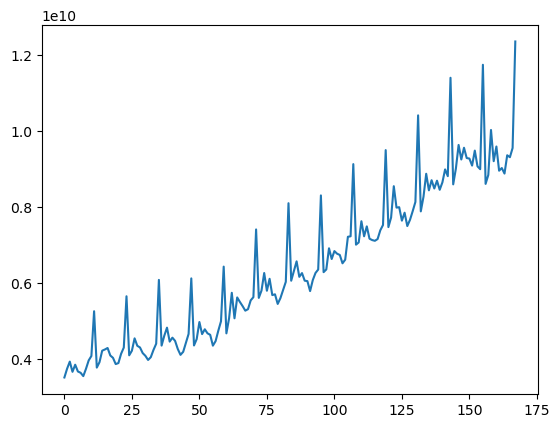

In [2]:
# numpyを使う
# ここでは元系列のまま分析を行う
series = np.loadtxt("../public/full_monthly_sales_without_header.csv")
plt.plot(series)
plt.show()

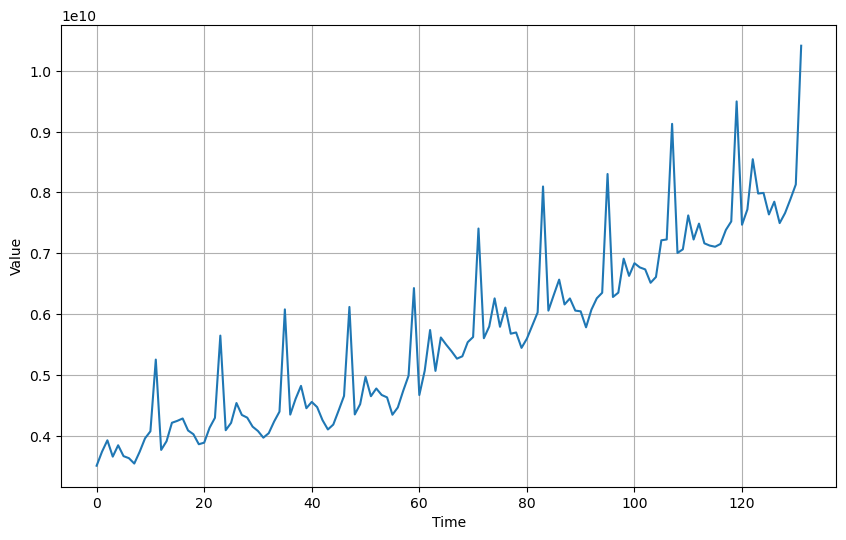

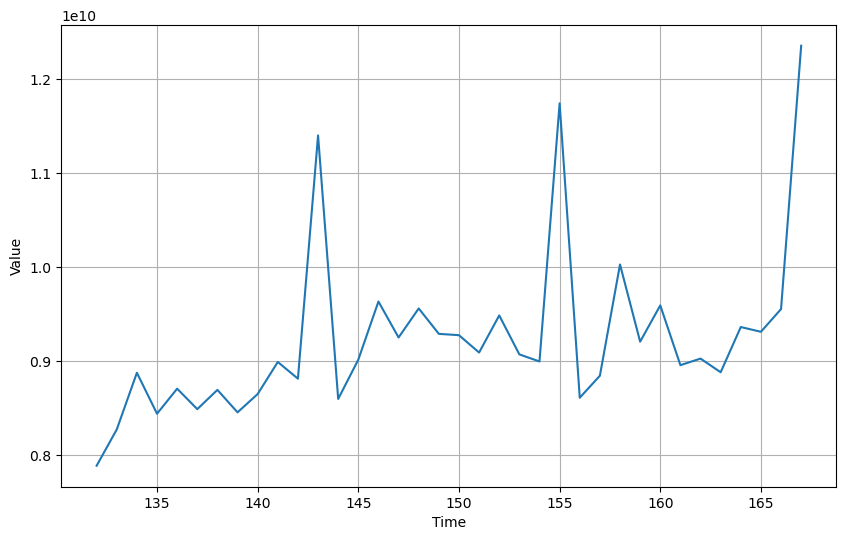

In [3]:
# 前半132時点を学習データ、以降を36時点を検証データとして分割

split_time = 132
time = np.arange(168, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_train_pred = time[20:split_time]
time_valid = time[split_time:168]
x_valid = series[split_time:168]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [63]:
# DNN

In [5]:
%%time
# PReLU・エポック数500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

2023-01-08 14:57:05.925800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 708ms/step - loss: 22.4466
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 20.2226
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 17.7872
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 15.6988
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 13.8567
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 12.4061
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 11.3330
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 10.5909
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 10.1433
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 9.8709
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 9.7190
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 9.5895
Epoch 13/500
4/4 [==============================] - 0s 6ms/ste

4/4 [==============================] - 0s 4ms/step - loss: 8.4780
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4741
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4691
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4639
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4626
Epoch 211/500
4/4 [==============================] - 0s 6ms/step - loss: 8.4569
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4771
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4657
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4566
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4480
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4597
Epoch 217/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4437
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 12ms/step - loss: 8.0255
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0283
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0211
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 8.0303
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 8.0305
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0242
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0133
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 8.0151
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0100
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 8.0111
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0006
Epoch 421/500
4/4 [==============================] - 0s 6ms/step - loss: 8.0069
Epoch 422/500
4/4 [==============================] - 

1/1 [==============================] - 0s 27ms/step


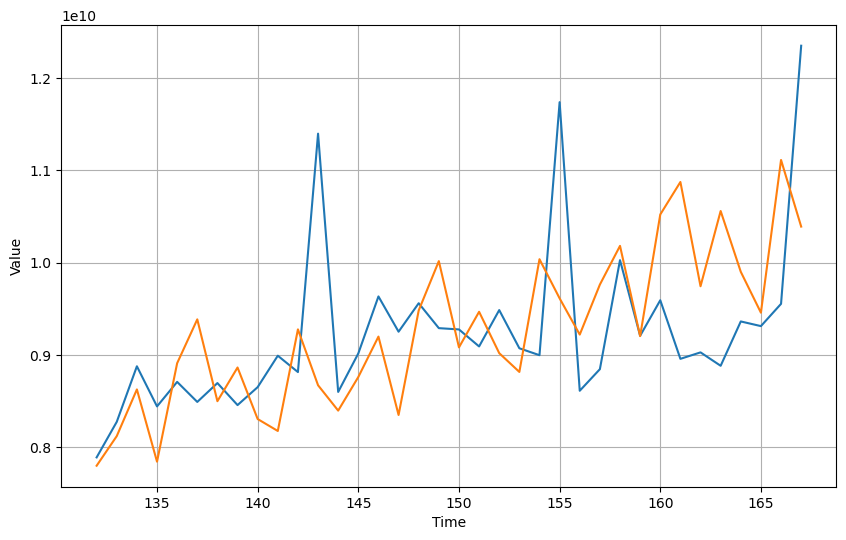

In [6]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [7]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.07331798872148004


In [8]:
%%time
# PReLU・エポック数500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 22ms/step - loss: 217.4108
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 214.0185
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 210.2835
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 206.6183
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 203.0487
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 199.5427
Epoch 7/500
4/4 [==============================] - 0s 29ms/step - loss: 196.0947
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 192.7817
Epoch 9/500
4/4 [==============================] - 0s 13ms/step - loss: 189.5444
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 186.3698
Epoch 11/500
4/4 [==============================] - 0s 21ms/step - loss: 183.2629
Epoch 12/500
4/4 [==============================] - 0s 8ms/step - loss: 180.2183
Epoch 13/500
4/4 [=========================

4/4 [==============================] - 0s 5ms/step - loss: 8.8233
Epoch 204/500
4/4 [==============================] - 0s 8ms/step - loss: 8.8190
Epoch 205/500
4/4 [==============================] - 0s 4ms/step - loss: 8.8148
Epoch 206/500
4/4 [==============================] - 0s 5ms/step - loss: 8.8108
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 8.8103
Epoch 208/500
4/4 [==============================] - 0s 6ms/step - loss: 8.8049
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 8.8004
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7970
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 8.7937
Epoch 212/500
4/4 [==============================] - 0s 7ms/step - loss: 8.7893
Epoch 213/500
4/4 [==============================] - 0s 16ms/step - loss: 8.7865
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 8.7831
Epoch 215/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 8.5404
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5427
Epoch 409/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5391
Epoch 410/500
4/4 [==============================] - 0s 8ms/step - loss: 8.5384
Epoch 411/500
4/4 [==============================] - 0s 7ms/step - loss: 8.5381
Epoch 412/500
4/4 [==============================] - 0s 6ms/step - loss: 8.5362
Epoch 413/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5357
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5344
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5370
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5326
Epoch 417/500
4/4 [==============================] - 0s 10ms/step - loss: 8.5347
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5351
Epoch 419/500
4/4 [==============================] - 

1/1 [==============================] - 0s 31ms/step


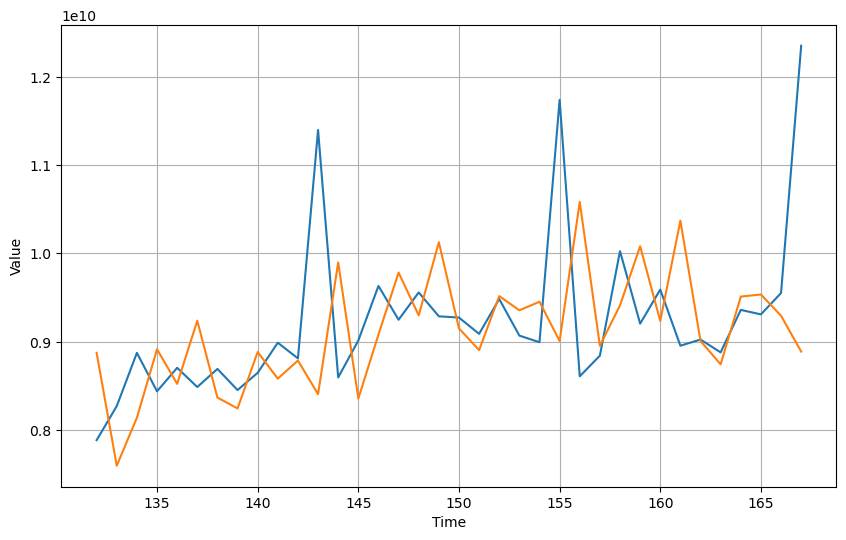

In [9]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [10]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.07292974572287166


In [11]:
%%time
# PReLU・エポック数1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 55ms/step - loss: 63.4732
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 59.5475
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 55.1180
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 50.6227
Epoch 5/1000
4/4 [==============================] - 0s 23ms/step - loss: 46.1110
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 41.5891
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 37.0459
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 32.4840
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 27.9120
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 23.3680
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 19.0857
Epoch 12/1000
4/4 [==============================] - 0s 4ms/step - loss: 15.5050
Epoch 13/1000
4/4 [===========================

Epoch 202/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0925
Epoch 203/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.0511
Epoch 204/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0380
Epoch 205/1000
4/4 [==============================] - 0s 10ms/step - loss: 10.0429
Epoch 206/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.0405
Epoch 207/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.0439
Epoch 208/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.0417
Epoch 209/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0368
Epoch 210/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0390
Epoch 211/1000
4/4 [==============================] - 0s 7ms/step - loss: 10.0279
Epoch 212/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0274
Epoch 213/1000
4/4 [==============================] - 0s 3ms/step - loss: 10.0255
Epoch 214/1000


4/4 [==============================] - 0s 3ms/step - loss: 9.6357
Epoch 404/1000
4/4 [==============================] - 0s 8ms/step - loss: 9.6786
Epoch 405/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.6313
Epoch 406/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.6488
Epoch 407/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.6377
Epoch 408/1000
4/4 [==============================] - 0s 7ms/step - loss: 9.6354
Epoch 409/1000
4/4 [==============================] - 0s 14ms/step - loss: 9.6541
Epoch 410/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.6327
Epoch 411/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.6421
Epoch 412/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.6346
Epoch 413/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.6238
Epoch 414/1000
4/4 [==============================] - 0s 8ms/step - loss: 9.6298
Epoch 415/1000
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 9.3104
Epoch 606/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.2740
Epoch 607/1000
4/4 [==============================] - 0s 8ms/step - loss: 9.2706
Epoch 608/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.2794
Epoch 609/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.2599
Epoch 610/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.2674
Epoch 611/1000
4/4 [==============================] - 0s 6ms/step - loss: 9.2618
Epoch 612/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.2787
Epoch 613/1000
4/4 [==============================] - 0s 5ms/step - loss: 9.2635
Epoch 614/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.2573
Epoch 615/1000
4/4 [==============================] - 0s 3ms/step - loss: 9.2642
Epoch 616/1000
4/4 [==============================] - 0s 6ms/step - loss: 9.2434
Epoch 617/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 8.9323
Epoch 808/1000
4/4 [==============================] - 0s 6ms/step - loss: 8.9269
Epoch 809/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9289
Epoch 810/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9269
Epoch 811/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.9407
Epoch 812/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.9319
Epoch 813/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9204
Epoch 814/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9554
Epoch 815/1000
4/4 [==============================] - 0s 5ms/step - loss: 8.9239
Epoch 816/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.9293
Epoch 817/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9113
Epoch 818/1000
4/4 [==============================] - 0s 3ms/step - loss: 8.9143
Epoch 819/1000
4/4 [=======================

1/1 [==============================] - 0s 17ms/step


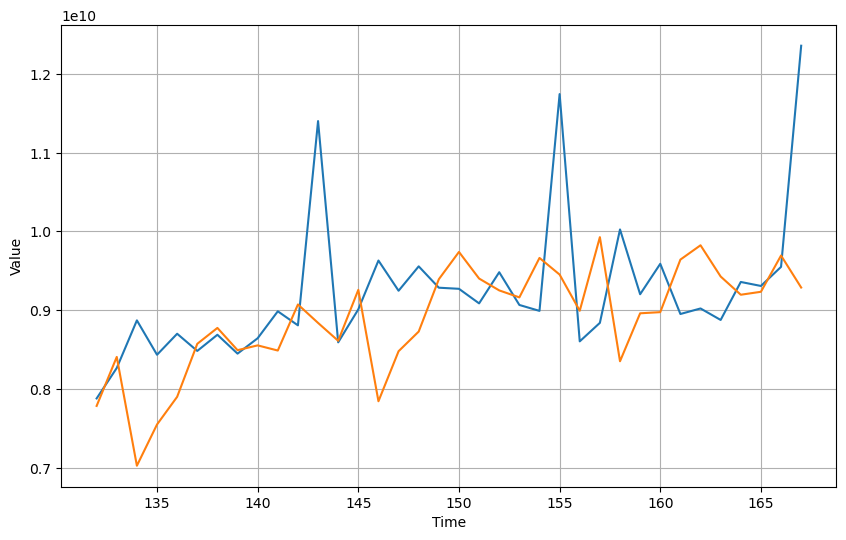

In [12]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [13]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.06960235627046302


In [14]:
%%time
# PReLU・エポック数2000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=2000,verbose=1)

Epoch 1/2000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 13ms/step - loss: 79.3084
Epoch 2/2000
4/4 [==============================] - 0s 4ms/step - loss: 78.9864
Epoch 3/2000
4/4 [==============================] - 0s 5ms/step - loss: 78.6339
Epoch 4/2000
4/4 [==============================] - 0s 6ms/step - loss: 78.2909
Epoch 5/2000
4/4 [==============================] - 0s 4ms/step - loss: 77.9555
Epoch 6/2000
4/4 [==============================] - 0s 3ms/step - loss: 77.6268
Epoch 7/2000
4/4 [==============================] - 0s 4ms/step - loss: 77.3030
Epoch 8/2000
4/4 [==============================] - 0s 3ms/step - loss: 76.9805
Epoch 9/2000
4/4 [==============================] - 0s 3ms/step - loss: 76.6586
Epoch 10/2000
4/4 [==============================] - 0s 4ms/step - loss: 76.3346
Epoch 11/2000
4/4 [==============================] - 0s 7ms/step - loss: 76.0116
Epoch 12/2000
4/4 [==============================] - 0s 12ms/step - loss: 75.6886
Epoch 13/2000
4/4 [=============================

4/4 [==============================] - 0s 6ms/step - loss: 8.1116
Epoch 203/2000
4/4 [==============================] - 0s 7ms/step - loss: 8.0838
Epoch 204/2000
4/4 [==============================] - 0s 4ms/step - loss: 8.0652
Epoch 205/2000
4/4 [==============================] - 0s 5ms/step - loss: 8.0507
Epoch 206/2000
4/4 [==============================] - 0s 3ms/step - loss: 8.0361
Epoch 207/2000
4/4 [==============================] - 0s 6ms/step - loss: 8.0196
Epoch 208/2000
4/4 [==============================] - 0s 6ms/step - loss: 8.0075
Epoch 209/2000
4/4 [==============================] - 0s 9ms/step - loss: 7.9996
Epoch 210/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.9940
Epoch 211/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9920
Epoch 212/2000
4/4 [==============================] - 0s 11ms/step - loss: 7.9895
Epoch 213/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.9902
Epoch 214/2000
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 7.9319
Epoch 304/2000
4/4 [==============================] - 0s 33ms/step - loss: 7.9325
Epoch 305/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9326
Epoch 306/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9287
Epoch 307/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9307
Epoch 308/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.9290
Epoch 309/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.9277
Epoch 310/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9283
Epoch 311/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9269
Epoch 312/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.9282
Epoch 313/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.9261
Epoch 314/2000
4/4 [==============================] - 0s 14ms/step - loss: 7.9256
Epoch 315/2000
4/4 [=====================

4/4 [==============================] - 0s 6ms/step - loss: 7.8837
Epoch 405/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8818
Epoch 406/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.8812
Epoch 407/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.8820
Epoch 408/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.8818
Epoch 409/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.8789
Epoch 410/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.8794
Epoch 411/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8809
Epoch 412/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8819
Epoch 413/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.8783
Epoch 414/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.8788
Epoch 415/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.8840
Epoch 416/2000
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 7.8361
Epoch 506/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.8348
Epoch 507/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8355
Epoch 508/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8364
Epoch 509/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.8331
Epoch 510/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8344
Epoch 511/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.8333
Epoch 512/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.8351
Epoch 513/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8329
Epoch 514/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8313
Epoch 515/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8335
Epoch 516/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.8308
Epoch 517/2000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 7.7890
Epoch 607/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.7888
Epoch 608/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.7888
Epoch 609/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.7877
Epoch 610/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7870
Epoch 611/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.7943
Epoch 612/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7902
Epoch 613/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.7876
Epoch 614/2000
4/4 [==============================] - 0s 10ms/step - loss: 7.7853
Epoch 615/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.7846
Epoch 616/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7868
Epoch 617/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.7846
Epoch 618/2000
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 7.7011
Epoch 809/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7010
Epoch 810/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.7032
Epoch 811/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.7001
Epoch 812/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7024
Epoch 813/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.6991
Epoch 814/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.6982
Epoch 815/2000
4/4 [==============================] - 0s 9ms/step - loss: 7.6987
Epoch 816/2000
4/4 [==============================] - 0s 16ms/step - loss: 7.6986
Epoch 817/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.7022
Epoch 818/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6977
Epoch 819/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.6950
Epoch 820/2000
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 7.6182
Epoch 1011/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.6177
Epoch 1012/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6182
Epoch 1013/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.6189
Epoch 1014/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6168
Epoch 1015/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6157
Epoch 1016/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.6180
Epoch 1017/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.6148
Epoch 1018/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.6150
Epoch 1019/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6149
Epoch 1020/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.6134
Epoch 1021/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.6135
Epoch 1022/2000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 7.5805
Epoch 1111/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5815
Epoch 1112/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5829
Epoch 1113/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5784
Epoch 1114/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5791
Epoch 1115/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5796
Epoch 1116/2000
4/4 [==============================] - 0s 10ms/step - loss: 7.5809
Epoch 1117/2000
4/4 [==============================] - 0s 11ms/step - loss: 7.5881
Epoch 1118/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.5781
Epoch 1119/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.5817
Epoch 1120/2000
4/4 [==============================] - 0s 9ms/step - loss: 7.5849
Epoch 1121/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.5833
Epoch 1122/2000
4/4 [=========

4/4 [==============================] - 0s 4ms/step - loss: 7.5459
Epoch 1211/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.5441
Epoch 1212/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.5435
Epoch 1213/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5428
Epoch 1214/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5430
Epoch 1215/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5427
Epoch 1216/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.5418
Epoch 1217/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5427
Epoch 1218/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5419
Epoch 1219/2000
4/4 [==============================] - 0s 16ms/step - loss: 7.5406
Epoch 1220/2000
4/4 [==============================] - 0s 12ms/step - loss: 7.5417
Epoch 1221/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.5421
Epoch 1222/2000
4/4 [=========

4/4 [==============================] - 0s 12ms/step - loss: 7.5117
Epoch 1311/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.5100
Epoch 1312/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5119
Epoch 1313/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.5095
Epoch 1314/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5094
Epoch 1315/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5072
Epoch 1316/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5132
Epoch 1317/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.5072
Epoch 1318/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5073
Epoch 1319/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.5063
Epoch 1320/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.5082
Epoch 1321/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.5059
Epoch 1322/2000
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 7.4731
Epoch 1411/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4760
Epoch 1412/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4732
Epoch 1413/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.4739
Epoch 1414/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.4723
Epoch 1415/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4723
Epoch 1416/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4714
Epoch 1417/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4755
Epoch 1418/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4712
Epoch 1419/2000
4/4 [==============================] - 0s 41ms/step - loss: 7.4719
Epoch 1420/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.4706
Epoch 1421/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4716
Epoch 1422/2000
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 7.4392
Epoch 1511/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.4397
Epoch 1512/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4400
Epoch 1513/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4398
Epoch 1514/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.4378
Epoch 1515/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.4385
Epoch 1516/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.4413
Epoch 1517/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.4423
Epoch 1518/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4360
Epoch 1519/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4383
Epoch 1520/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4371
Epoch 1521/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.4375
Epoch 1522/2000
4/4 [===========

Epoch 1610/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4068
Epoch 1611/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4073
Epoch 1612/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4063
Epoch 1613/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4059
Epoch 1614/2000
4/4 [==============================] - 0s 10ms/step - loss: 7.4068
Epoch 1615/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.4059
Epoch 1616/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4040
Epoch 1617/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4048
Epoch 1618/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4052
Epoch 1619/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.4050
Epoch 1620/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4033
Epoch 1621/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.4032
Epoch 1622/2000

4/4 [==============================] - 0s 4ms/step - loss: 7.3427
Epoch 1810/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3413
Epoch 1811/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3452
Epoch 1812/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3407
Epoch 1813/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.3430
Epoch 1814/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3416
Epoch 1815/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.3424
Epoch 1816/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3441
Epoch 1817/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.3434
Epoch 1818/2000
4/4 [==============================] - 0s 13ms/step - loss: 7.3445
Epoch 1819/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3431
Epoch 1820/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.3385
Epoch 1821/2000
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 7.3108
Epoch 1910/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3110
Epoch 1911/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3121
Epoch 1912/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3109
Epoch 1913/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3105
Epoch 1914/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3107
Epoch 1915/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3099
Epoch 1916/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.3102
Epoch 1917/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.3103
Epoch 1918/2000
4/4 [==============================] - 0s 10ms/step - loss: 7.3085
Epoch 1919/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3094
Epoch 1920/2000
4/4 [==============================] - 0s 3ms/step - loss: 7.3104
Epoch 1921/2000
4/4 [==========

1/1 [==============================] - 0s 48ms/step


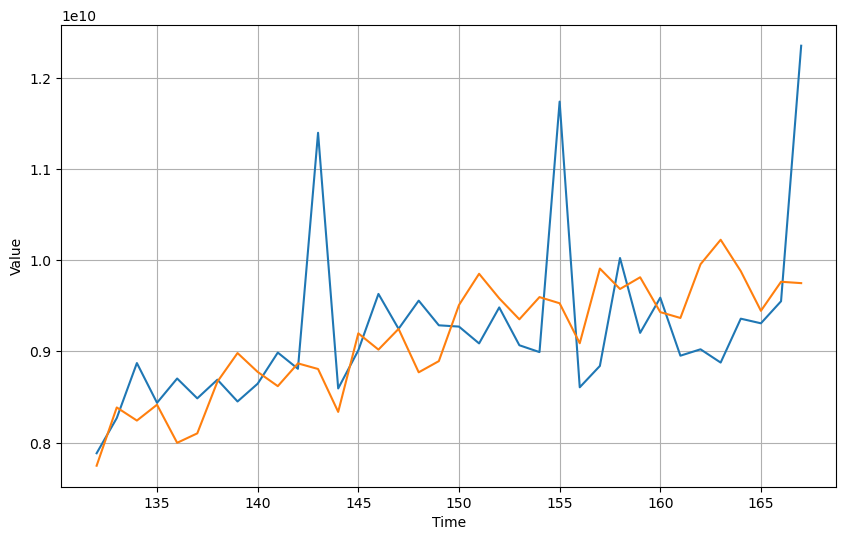

In [15]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [16]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05919751186498068


In [17]:
%%time
# PReLU・エポック数5000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=5000,verbose=1)

Epoch 1/5000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 52ms/step - loss: 18.6488
Epoch 2/5000
4/4 [==============================] - 0s 8ms/step - loss: 17.9683
Epoch 3/5000
4/4 [==============================] - 0s 4ms/step - loss: 17.1959
Epoch 4/5000
4/4 [==============================] - 0s 3ms/step - loss: 16.4136
Epoch 5/5000
4/4 [==============================] - 0s 5ms/step - loss: 15.6254
Epoch 6/5000
4/4 [==============================] - 0s 6ms/step - loss: 14.8305
Epoch 7/5000
4/4 [==============================] - 0s 3ms/step - loss: 14.0294
Epoch 8/5000
4/4 [==============================] - 0s 5ms/step - loss: 13.2251
Epoch 9/5000
4/4 [==============================] - 0s 3ms/step - loss: 12.4383
Epoch 10/5000
4/4 [==============================] - 0s 4ms/step - loss: 11.6850
Epoch 11/5000
4/4 [==============================] - 0s 3ms/step - loss: 10.9917
Epoch 12/5000
4/4 [==============================] - 0s 4ms/step - loss: 10.3703
Epoch 13/5000
4/4 [==============================

4/4 [==============================] - 0s 3ms/step - loss: 6.8025
Epoch 205/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8035
Epoch 206/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8049
Epoch 207/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7993
Epoch 208/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8020
Epoch 209/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7994
Epoch 210/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7993
Epoch 211/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.7993
Epoch 212/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7983
Epoch 213/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7971
Epoch 214/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7970
Epoch 215/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7962
Epoch 216/5000
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 6.7340
Epoch 407/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.7288
Epoch 408/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.7292
Epoch 409/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.7311
Epoch 410/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7284
Epoch 411/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7316
Epoch 412/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7273
Epoch 413/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7294
Epoch 414/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7268
Epoch 415/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7258
Epoch 416/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7250
Epoch 417/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7240
Epoch 418/5000
4/4 [====================

4/4 [==============================] - 0s 13ms/step - loss: 6.6597
Epoch 609/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6607
Epoch 610/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6596
Epoch 611/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.6575
Epoch 612/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6583
Epoch 613/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6566
Epoch 614/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6561
Epoch 615/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.6570
Epoch 616/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.6565
Epoch 617/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.6562
Epoch 618/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6553
Epoch 619/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.6574
Epoch 620/5000
4/4 [=====================

4/4 [==============================] - 0s 6ms/step - loss: 6.5913
Epoch 811/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.5904
Epoch 812/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5910
Epoch 813/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5886
Epoch 814/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5893
Epoch 815/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5907
Epoch 816/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5870
Epoch 817/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5880
Epoch 818/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.5895
Epoch 819/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5904
Epoch 820/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5861
Epoch 821/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5868
Epoch 822/5000
4/4 [=====================

4/4 [==============================] - 0s 5ms/step - loss: 6.5243
Epoch 1013/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5204
Epoch 1014/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5222
Epoch 1015/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5223
Epoch 1016/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5241
Epoch 1017/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5199
Epoch 1018/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.5197
Epoch 1019/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5200
Epoch 1020/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5203
Epoch 1021/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5215
Epoch 1022/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5188
Epoch 1023/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5192
Epoch 1024/5000
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 6.4857
Epoch 1113/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4885
Epoch 1114/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4864
Epoch 1115/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4878
Epoch 1116/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4863
Epoch 1117/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4884
Epoch 1118/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.4854
Epoch 1119/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4847
Epoch 1120/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4861
Epoch 1121/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4869
Epoch 1122/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4853
Epoch 1123/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.4828
Epoch 1124/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 6.4537
Epoch 1213/5000
4/4 [==============================] - 0s 15ms/step - loss: 6.4538
Epoch 1214/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4586
Epoch 1215/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4521
Epoch 1216/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4537
Epoch 1217/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4538
Epoch 1218/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.4512
Epoch 1219/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4517
Epoch 1220/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4502
Epoch 1221/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4503
Epoch 1222/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4505
Epoch 1223/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4499
Epoch 1224/5000
4/4 [==========

Epoch 1312/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.4193
Epoch 1313/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4204
Epoch 1314/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4209
Epoch 1315/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4218
Epoch 1316/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4167
Epoch 1317/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.4178
Epoch 1318/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4179
Epoch 1319/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4172
Epoch 1320/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4195
Epoch 1321/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.4176
Epoch 1322/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4182
Epoch 1323/5000
4/4 [==============================] - 0s 26ms/step - loss: 6.4185
Epoch 1324/500

4/4 [==============================] - 0s 6ms/step - loss: 6.3554
Epoch 1511/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3549
Epoch 1512/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.3525
Epoch 1513/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3536
Epoch 1514/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3536
Epoch 1515/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.3534
Epoch 1516/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3560
Epoch 1517/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3617
Epoch 1518/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3533
Epoch 1519/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3516
Epoch 1520/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.3509
Epoch 1521/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3501
Epoch 1522/5000
4/4 [===========

Epoch 1610/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3231
Epoch 1611/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3239
Epoch 1612/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3242
Epoch 1613/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3236
Epoch 1614/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3247
Epoch 1615/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3220
Epoch 1616/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3225
Epoch 1617/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3225
Epoch 1618/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3206
Epoch 1619/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3211
Epoch 1620/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3232
Epoch 1621/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3203
Epoch 1622/5000


4/4 [==============================] - 0s 4ms/step - loss: 6.2689
Epoch 1810/5000
4/4 [==============================] - 0s 19ms/step - loss: 6.2647
Epoch 1811/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.2656
Epoch 1812/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2647
Epoch 1813/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.2645
Epoch 1814/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2640
Epoch 1815/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2651
Epoch 1816/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2649
Epoch 1817/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.2629
Epoch 1818/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.2651
Epoch 1819/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2657
Epoch 1820/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2637
Epoch 1821/5000
4/4 [==========

Epoch 1909/5000
4/4 [==============================] - 0s 2ms/step - loss: 6.2361
Epoch 1910/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2375
Epoch 1911/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2358
Epoch 1912/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2371
Epoch 1913/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.2369
Epoch 1914/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2359
Epoch 1915/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.2365
Epoch 1916/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.2359
Epoch 1917/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2366
Epoch 1918/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2350
Epoch 1919/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.2356
Epoch 1920/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2384
Epoch 1921/5000


4/4 [==============================] - 0s 3ms/step - loss: 6.1802
Epoch 2109/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1800
Epoch 2110/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1818
Epoch 2111/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1803
Epoch 2112/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1789
Epoch 2113/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1786
Epoch 2114/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1798
Epoch 2115/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1801
Epoch 2116/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1784
Epoch 2117/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1794
Epoch 2118/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.1807
Epoch 2119/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1787
Epoch 2120/5000
4/4 [===========

Epoch 2208/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1549
Epoch 2209/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1535
Epoch 2210/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1539
Epoch 2211/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1565
Epoch 2212/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.1533
Epoch 2213/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.1537
Epoch 2214/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1541
Epoch 2215/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1527
Epoch 2216/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1536
Epoch 2217/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1540
Epoch 2218/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1528
Epoch 2219/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1516
Epoch 2220/5000


Epoch 2407/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.1057
Epoch 2408/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1062
Epoch 2409/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1075
Epoch 2410/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1118
Epoch 2411/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1072
Epoch 2412/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1048
Epoch 2413/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.1091
Epoch 2414/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1051
Epoch 2415/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1067
Epoch 2416/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1044
Epoch 2417/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1039
Epoch 2418/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1052
Epoch 2419/5000


Epoch 2606/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0580
Epoch 2607/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0573
Epoch 2608/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.0579
Epoch 2609/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0581
Epoch 2610/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0628
Epoch 2611/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.0563
Epoch 2612/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0573
Epoch 2613/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0565
Epoch 2614/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0571
Epoch 2615/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.0601
Epoch 2616/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0563
Epoch 2617/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0575
Epoch 2618/500

4/4 [==============================] - 0s 3ms/step - loss: 6.0124
Epoch 2806/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.0132
Epoch 2807/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0109
Epoch 2808/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.0118
Epoch 2809/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0113
Epoch 2810/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0116
Epoch 2811/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0099
Epoch 2812/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0112
Epoch 2813/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0142
Epoch 2814/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0102
Epoch 2815/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0141
Epoch 2816/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0129
Epoch 2817/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 5.9952
Epoch 2906/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9914
Epoch 2907/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9901
Epoch 2908/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9916
Epoch 2909/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9908
Epoch 2910/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9911
Epoch 2911/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9892
Epoch 2912/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9987
Epoch 2913/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9929
Epoch 2914/5000
4/4 [==============================] - 0s 29ms/step - loss: 5.9893
Epoch 2915/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9889
Epoch 2916/5000
4/4 [==============================] - 0s 29ms/step - loss: 5.9892
Epoch 2917/5000
4/4 [=========

4/4 [==============================] - 0s 3ms/step - loss: 5.9697
Epoch 3006/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9726
Epoch 3007/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9690
Epoch 3008/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9742
Epoch 3009/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9690
Epoch 3010/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9706
Epoch 3011/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9686
Epoch 3012/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9686
Epoch 3013/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9677
Epoch 3014/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9685
Epoch 3015/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9687
Epoch 3016/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.9679
Epoch 3017/5000
4/4 [===========

4/4 [==============================] - 0s 11ms/step - loss: 5.9537
Epoch 3106/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9547
Epoch 3107/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9488
Epoch 3108/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9490
Epoch 3109/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9514
Epoch 3110/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9534
Epoch 3111/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9497
Epoch 3112/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9498
Epoch 3113/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9494
Epoch 3114/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9521
Epoch 3115/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9506
Epoch 3116/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9491
Epoch 3117/5000
4/4 [==========

Epoch 3205/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9330
Epoch 3206/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9312
Epoch 3207/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9305
Epoch 3208/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.9330
Epoch 3209/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9290
Epoch 3210/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9316
Epoch 3211/5000
4/4 [==============================] - 0s 14ms/step - loss: 5.9284
Epoch 3212/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.9303
Epoch 3213/5000
4/4 [==============================] - 0s 14ms/step - loss: 5.9284
Epoch 3214/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9286
Epoch 3215/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9305
Epoch 3216/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9292
Epoch 3217/5

4/4 [==============================] - 0s 3ms/step - loss: 5.8923
Epoch 3405/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8921
Epoch 3406/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8907
Epoch 3407/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8906
Epoch 3408/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8905
Epoch 3409/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8934
Epoch 3410/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8909
Epoch 3411/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8934
Epoch 3412/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.8904
Epoch 3413/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8885
Epoch 3414/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8887
Epoch 3415/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8880
Epoch 3416/5000
4/4 [==========

Epoch 3504/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8719
Epoch 3505/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.8714
Epoch 3506/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8712
Epoch 3507/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.8728
Epoch 3508/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8702
Epoch 3509/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8699
Epoch 3510/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8765
Epoch 3511/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8724
Epoch 3512/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8689
Epoch 3513/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8705
Epoch 3514/5000
4/4 [==============================] - 0s 17ms/step - loss: 5.8695
Epoch 3515/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8704
Epoch 3516/5000

Epoch 3703/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.8325
Epoch 3704/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8311
Epoch 3705/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8307
Epoch 3706/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8345
Epoch 3707/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8303
Epoch 3708/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8300
Epoch 3709/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8309
Epoch 3710/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8301
Epoch 3711/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.8303
Epoch 3712/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8305
Epoch 3713/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8296
Epoch 3714/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8300
Epoch 3715/5000


4/4 [==============================] - 0s 4ms/step - loss: 5.7915
Epoch 3903/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.7906
Epoch 3904/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7931
Epoch 3905/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.7917
Epoch 3906/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7925
Epoch 3907/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7944
Epoch 3908/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7918
Epoch 3909/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7947
Epoch 3910/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7902
Epoch 3911/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7891
Epoch 3912/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.7920
Epoch 3913/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.7887
Epoch 3914/5000
4/4 [=========

Epoch 4002/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.7723
Epoch 4003/5000
4/4 [==============================] - 0s 13ms/step - loss: 5.7730
Epoch 4004/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7714
Epoch 4005/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.7732
Epoch 4006/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7704
Epoch 4007/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.7701
Epoch 4008/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7721
Epoch 4009/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7715
Epoch 4010/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7709
Epoch 4011/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7732
Epoch 4012/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7698
Epoch 4013/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.7707
Epoch 4014/500

Epoch 4201/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.7340
Epoch 4202/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7329
Epoch 4203/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7338
Epoch 4204/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7330
Epoch 4205/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7322
Epoch 4206/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7330
Epoch 4207/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7330
Epoch 4208/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7317
Epoch 4209/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.7311
Epoch 4210/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7338
Epoch 4211/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7325
Epoch 4212/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7327
Epoch 4213/5000

4/4 [==============================] - 0s 4ms/step - loss: 5.6949
Epoch 4401/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6941
Epoch 4402/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6939
Epoch 4403/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6932
Epoch 4404/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6938
Epoch 4405/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6942
Epoch 4406/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7027
Epoch 4407/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7022
Epoch 4408/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6922
Epoch 4409/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.6926
Epoch 4410/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6917
Epoch 4411/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6953
Epoch 4412/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 5.6748
Epoch 4501/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.6734
Epoch 4502/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6719
Epoch 4503/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6734
Epoch 4504/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6719
Epoch 4505/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6737
Epoch 4506/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.6740
Epoch 4507/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6709
Epoch 4508/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6728
Epoch 4509/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6712
Epoch 4510/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6713
Epoch 4511/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6713
Epoch 4512/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 5.6500
Epoch 4601/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.6501
Epoch 4602/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6496
Epoch 4603/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6491
Epoch 4604/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6489
Epoch 4605/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6490
Epoch 4606/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.6479
Epoch 4607/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.6484
Epoch 4608/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6476
Epoch 4609/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6492
Epoch 4610/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6515
Epoch 4611/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6490
Epoch 4612/5000
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 5.6304
Epoch 4701/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6253
Epoch 4702/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6263
Epoch 4703/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6249
Epoch 4704/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6277
Epoch 4705/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6238
Epoch 4706/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6265
Epoch 4707/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6259
Epoch 4708/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6267
Epoch 4709/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6233
Epoch 4710/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6250
Epoch 4711/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6227
Epoch 4712/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 5.6065
Epoch 4801/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6036
Epoch 4802/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6004
Epoch 4803/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6045
Epoch 4804/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6022
Epoch 4805/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6005
Epoch 4806/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6021
Epoch 4807/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6015
Epoch 4808/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.6031
Epoch 4809/5000
4/4 [==============================] - 0s 2ms/step - loss: 5.6026
Epoch 4810/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6008
Epoch 4811/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6006
Epoch 4812/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 5.5809
Epoch 4901/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5785
Epoch 4902/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5804
Epoch 4903/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5817
Epoch 4904/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5828
Epoch 4905/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5776
Epoch 4906/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5783
Epoch 4907/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.5768
Epoch 4908/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.5776
Epoch 4909/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.5774
Epoch 4910/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5774
Epoch 4911/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.5787
Epoch 4912/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 5.5600
CPU times: user 5min 13s, sys: 47.4 s, total: 6min 1s
Wall time: 8min 17s


1/1 [==============================] - 0s 23ms/step


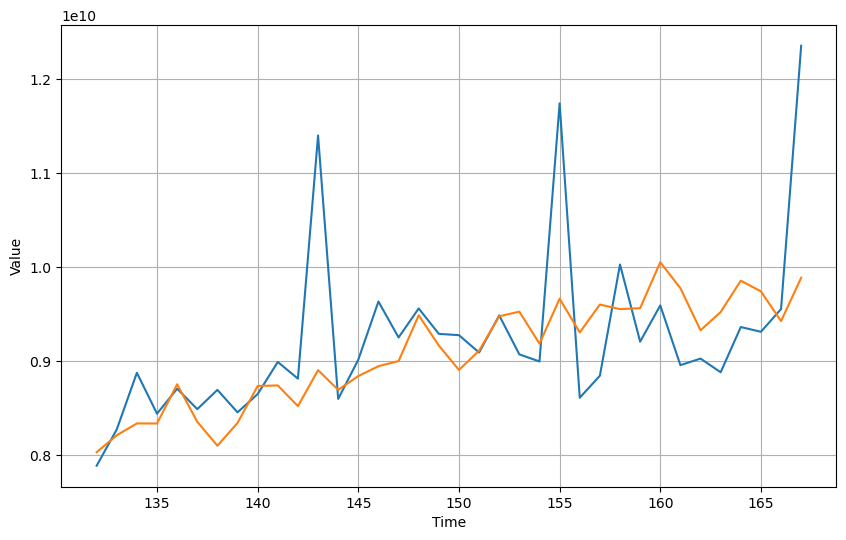

In [18]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [19]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.048436993847073555


In [20]:
# エポック数の上昇とともにMAPEが減少

In [21]:
%%time
# 学習率の大まかなエリアを絞り込む
# PReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


CPU times: user 29.2 s, sys: 4.02 s, total: 33.2 s
Wall time: 41.4 s


(1e-08, 0.001, 0.0, 300.0)

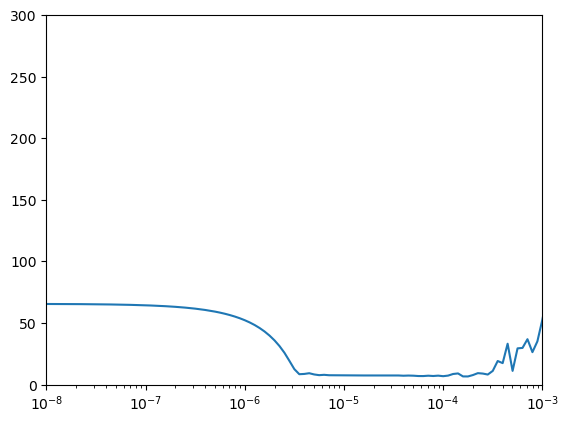

In [22]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 20.0)

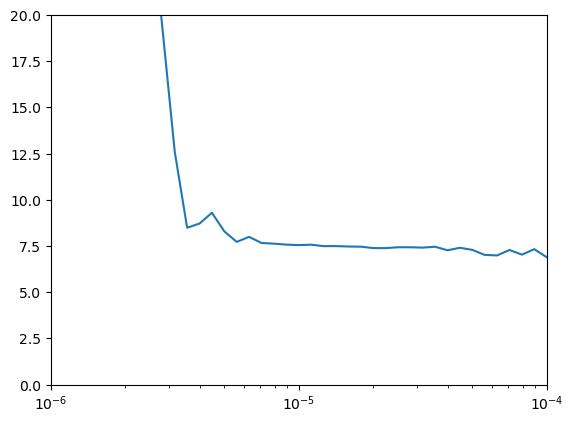

In [23]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [24]:
# 0.1〜1*10^-5くらいの学習率でMAPEが最小になる

In [25]:
# ここまでのパラメータのまとめ
# エポック数：500〜5000にかけて大きくMAPEは減少するが、他のプログラムの実行結果と比較しやすいようにするためにエポック数を500で固定。
# 学習率：0.1〜1*10^-5

In [26]:
# keras tunerでニューロンの数を試すための予備シミュレーションをする

In [27]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(5, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(5))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 2s 63ms/step - loss: 85.2711
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 82.2923
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 78.9298
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 75.5130
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 72.1988
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 68.3044
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 62.7869
Epoch 8/500
4/4 [==============================] - 0s 11ms/step - loss: 56.2831
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 49.0140
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 41.5628
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 33.8124
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 25.7476
Epoch 13/500
4/4 [=============================

4/4 [==============================] - 0s 5ms/step - loss: 6.8832
Epoch 207/500
4/4 [==============================] - 0s 10ms/step - loss: 6.8760
Epoch 208/500
4/4 [==============================] - 0s 8ms/step - loss: 6.8699
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8635
Epoch 210/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8922
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8562
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8744
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8674
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8854
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8488
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 6.8845
Epoch 217/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8457
Epoch 218/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 6.3870
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3580
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3562
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3508
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3455
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3475
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3438
Epoch 417/500
4/4 [==============================] - 0s 7ms/step - loss: 6.3684
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3288
Epoch 419/500
4/4 [==============================] - 0s 8ms/step - loss: 6.3777
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3552
Epoch 421/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3321
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 154ms/step


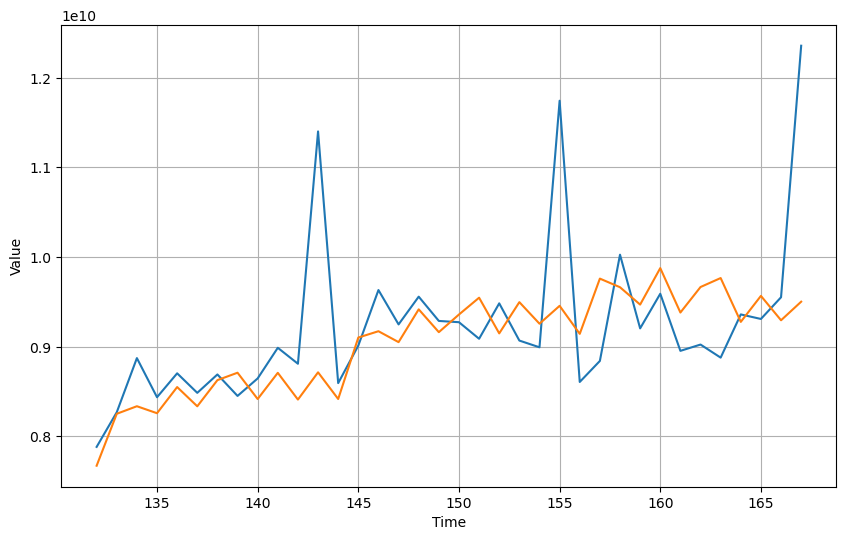

In [28]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [29]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.049709851065805645


In [30]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(15, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(15))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 3s 13ms/step - loss: 35.0905
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 15.5885
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 12.0991
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 11.9822
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 11.8931
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 11.7770
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 11.8108
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 11.8072
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 11.7308
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 11.6903
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 11.8614
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 11.7247
Epoch 13/500
4/4 [==============================] - 0s 4ms/s

4/4 [==============================] - 0s 6ms/step - loss: 8.0718
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0131
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9936
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 8.0876
Epoch 209/500
4/4 [==============================] - 0s 11ms/step - loss: 8.0707
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9978
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 7.9758
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 7.9523
Epoch 213/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0013
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 7.9517
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9096
Epoch 216/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9455
Epoch 217/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 6.4562
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3509
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3850
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4169
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2742
Epoch 414/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3365
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2902
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3471
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3283
Epoch 418/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3498
Epoch 419/500
4/4 [==============================] - 0s 11ms/step - loss: 6.2941
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3779
Epoch 421/500
4/4 [==============================] - 

1/1 [==============================] - 0s 27ms/step


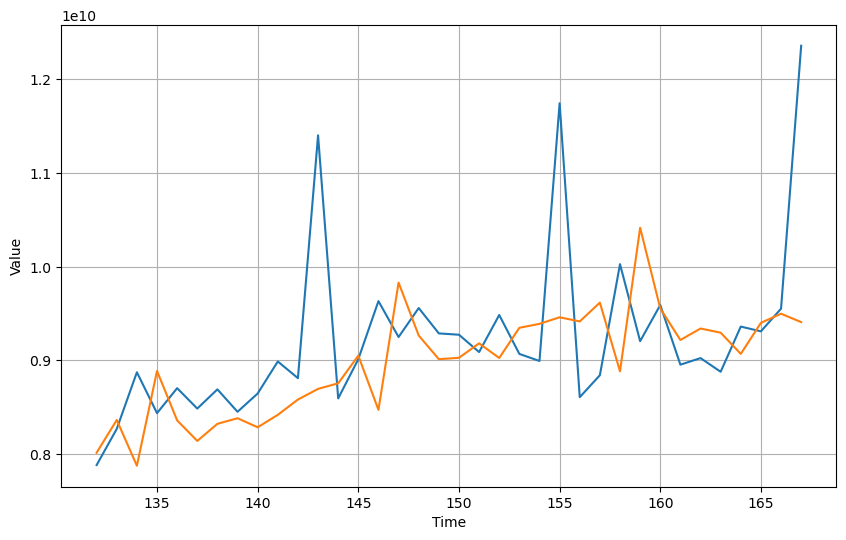

In [31]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [32]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.059437865175173465


In [33]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(20, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(20))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 17ms/step - loss: 111.1701
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 81.7314
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 49.4313
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 21.5045
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 9.5494
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 9.1372
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 8.9941
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 8.9333
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 8.8088
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 8.8176
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 8.6882
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7798
Epoch 13/500
4/4 [==============================] - 0s 3ms/step - 

4/4 [==============================] - 0s 4ms/step - loss: 6.3587
Epoch 207/500
4/4 [==============================] - 0s 6ms/step - loss: 6.4597
Epoch 208/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4067
Epoch 209/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3682
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4136
Epoch 211/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3831
Epoch 212/500
4/4 [==============================] - 0s 34ms/step - loss: 6.3225
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3752
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3373
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3481
Epoch 216/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3064
Epoch 217/500
4/4 [==============================] - 0s 12ms/step - loss: 6.3397
Epoch 218/500
4/4 [==============================] -

4/4 [==============================] - 0s 3ms/step - loss: 5.5302
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5917
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 5.7094
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5247
Epoch 414/500
4/4 [==============================] - 0s 6ms/step - loss: 5.5283
Epoch 415/500
4/4 [==============================] - 0s 8ms/step - loss: 5.5163
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 5.6256
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5629
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 5.4634
Epoch 419/500
4/4 [==============================] - 0s 6ms/step - loss: 5.5596
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5706
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5257
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 67ms/step


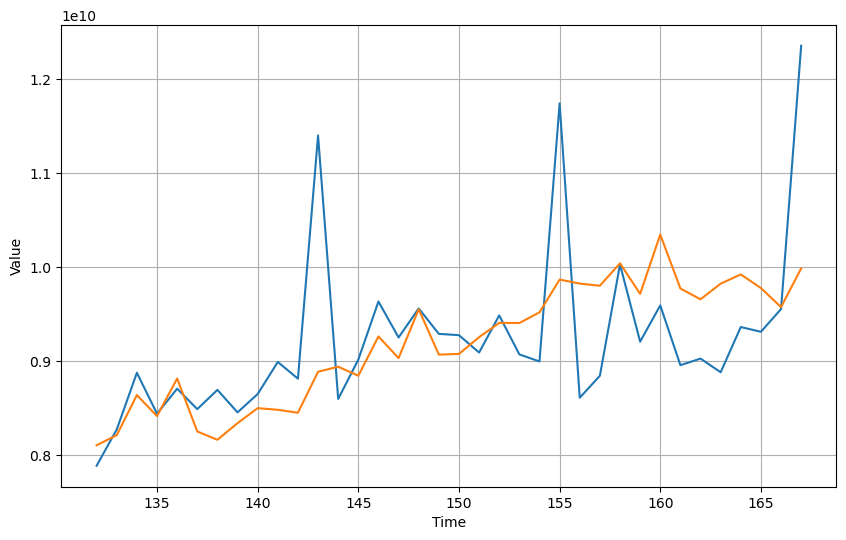

In [34]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [35]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05335231345884742


In [36]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(25, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(25))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 42ms/step - loss: 104.7984
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 93.4415
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 79.4271
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 64.1568
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 48.3230
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 32.2620
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 15.8512
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 7.5433
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 7.4324
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 7.3323
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 7.3365
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 7.3389
Epoch 13/500
4/4 [==============================] - 0s 5ms/step 

4/4 [==============================] - 0s 3ms/step - loss: 5.9153
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 5.8770
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 5.8781
Epoch 209/500
4/4 [==============================] - 0s 20ms/step - loss: 5.8968
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 5.9199
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 5.8742
Epoch 212/500
4/4 [==============================] - 0s 7ms/step - loss: 5.8765
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 5.8316
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 5.8708
Epoch 215/500
4/4 [==============================] - 0s 7ms/step - loss: 5.8340
Epoch 216/500
4/4 [==============================] - 0s 5ms/step - loss: 5.8451
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 5.8957
Epoch 218/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 5.0695
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0613
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 5.1051
Epoch 413/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0620
Epoch 414/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0440
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0471
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 5.1011
Epoch 417/500
4/4 [==============================] - 0s 45ms/step - loss: 5.0334
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1574
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 5.0798
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0629
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0620
Epoch 422/500
4/4 [==============================] - 

1/1 [==============================] - 0s 31ms/step


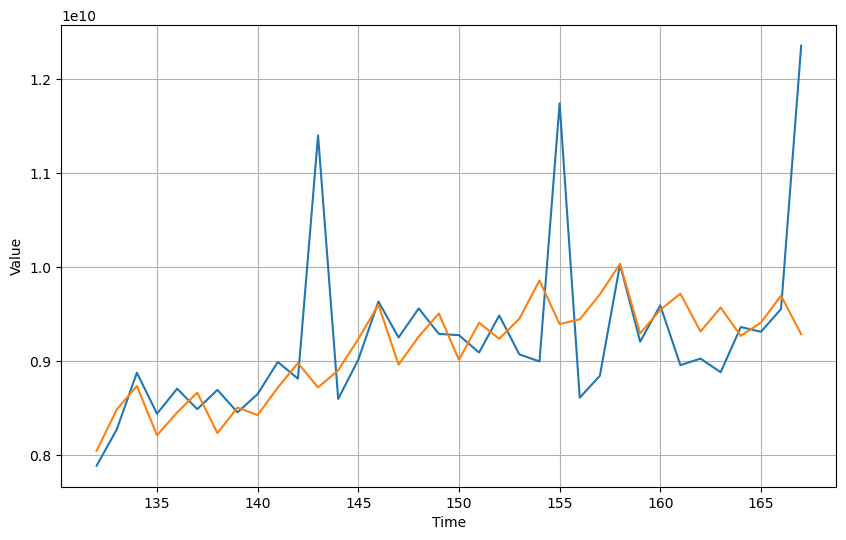

In [37]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [38]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.04926125204256648


In [39]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(30, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(30))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 2s 15ms/step - loss: 84.5267
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 74.3995
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 60.6744
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 45.5908
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 30.3993
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 16.3538
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 9.6133
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 9.3333
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 9.2034
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 9.1771
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 9.1109
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0757
Epoch 13/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 5.9404
Epoch 207/500
4/4 [==============================] - 0s 8ms/step - loss: 5.9842
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 5.9927
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0049
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 5.9353
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 5.9399
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 5.9192
Epoch 213/500
4/4 [==============================] - 0s 5ms/step - loss: 5.9378
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 6.0056
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 5.8991
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 5.9375
Epoch 217/500
4/4 [==============================] - 0s 4ms/step - loss: 5.8871
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 5.1586
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1589
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1450
Epoch 413/500
4/4 [==============================] - 0s 6ms/step - loss: 5.2866
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 5.2093
Epoch 415/500
4/4 [==============================] - 0s 7ms/step - loss: 5.1885
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1121
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0873
Epoch 418/500
4/4 [==============================] - 0s 11ms/step - loss: 5.0890
Epoch 419/500
4/4 [==============================] - 0s 6ms/step - loss: 5.1099
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 5.1274
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0799
Epoch 422/500
4/4 [==============================] - 

1/1 [==============================] - 0s 29ms/step


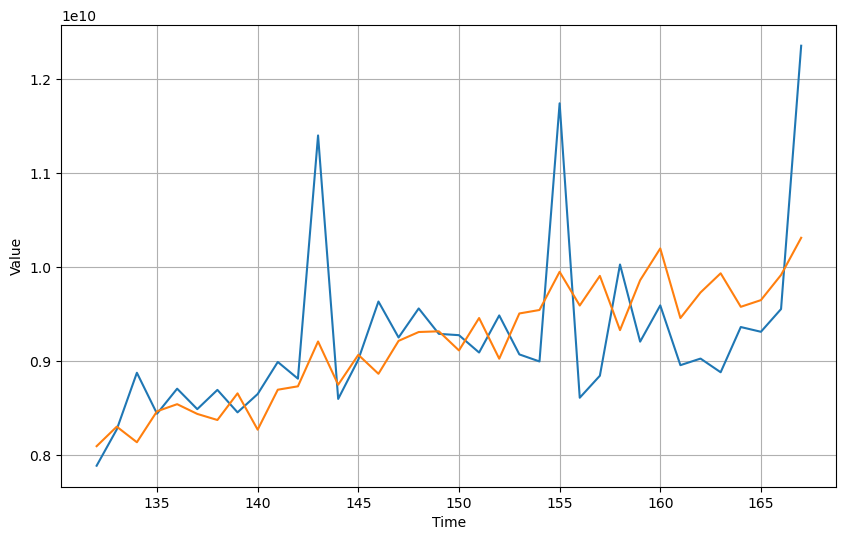

In [40]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [41]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.053855322006894496


In [42]:
%%time
# PReLU・エポック数500
# split_by_132/PReLU_500_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4)))
  model.add(PReLU())
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_132', project_name='PReLU_500_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.7, 0.9], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 12min 29s, sys: 9min 39s, total: 1h 22min 9s
Wall time: 1h 44min 56s


In [43]:
tuner.results_summary()

Results summary
Results in split_by_132/PReLU_500_1
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 26
units2: 22
momentum: 0.5
Score: 4.9244303703308105
Trial summary
Hyperparameters:
units1: 22
units2: 10
momentum: 0.9
Score: 4.925930500030518
Trial summary
Hyperparameters:
units1: 18
units2: 14
momentum: 0.7
Score: 5.092800458272298
Trial summary
Hyperparameters:
units1: 26
units2: 18
momentum: 0.7
Score: 5.174956242243449
Trial summary
Hyperparameters:
units1: 14
units2: 18
momentum: 0.9
Score: 5.256824016571045
Trial summary
Hyperparameters:
units1: 26
units2: 2
momentum: 0.5
Score: 5.29556147257487
Trial summary
Hyperparameters:
units1: 18
units2: 22
momentum: 0.7
Score: 5.376105308532715
Trial summary
Hyperparameters:
units1: 26
units2: 30
momentum: 0.7
Score: 5.431690692901611
Trial summary
Hyperparameters:
units1: 18
units2: 26
momentum: 0.5
Score: 5.45462433497111
Trial summary
Hyperparameters:
units1: 30
units2: 2
momentum: 0.5
Score: 5.474327405293782


In [59]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(26, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(22))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 12ms/step - loss: 163.1131
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 150.8580
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 139.3248
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 129.8201
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 121.5664
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 114.1791
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 107.4891
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 101.1277
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 95.0714
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 89.2061
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 83.3992
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 77.5552
Epoch 13/500
4/4 [==============================] -

4/4 [==============================] - 0s 2ms/step - loss: 5.1630
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1744
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1547
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1661
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1296
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1526
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1321
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1438
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1445
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1198
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 5.1247
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1577
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 4.4390
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4483
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4014
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4710
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4103
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4277
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4276
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4472
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 4.4719
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4072
Epoch 420/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4399
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4819
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 19ms/step


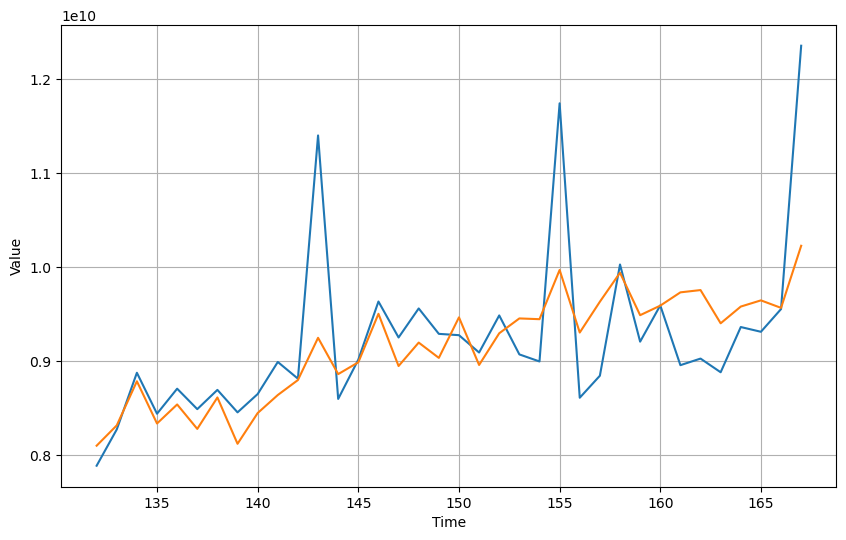

In [60]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [61]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.042051256440442636


In [64]:
dnn_forecast = forecast
dnn_train_pred = train_pred
dnn_test_pred = test_pred

In [73]:
# 一旦SARIMAXとDNNで考察する

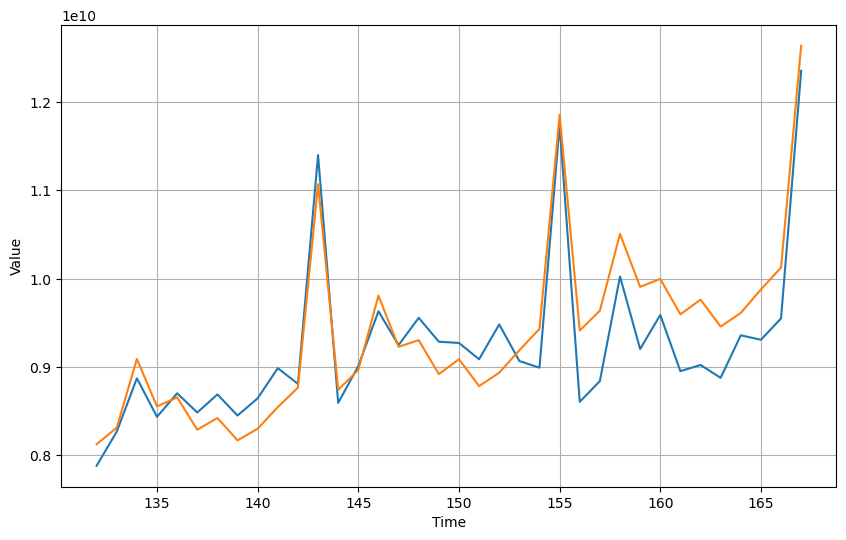

In [74]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

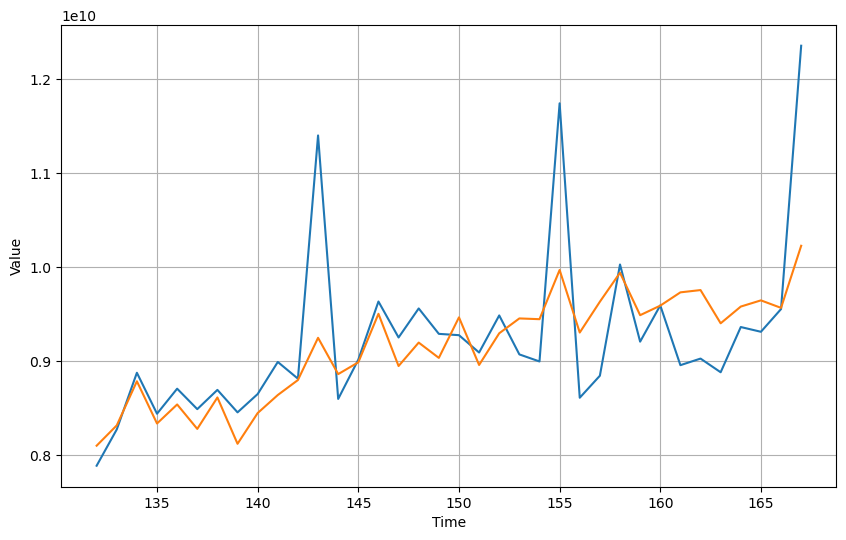

In [75]:
# DNN
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_test_pred)

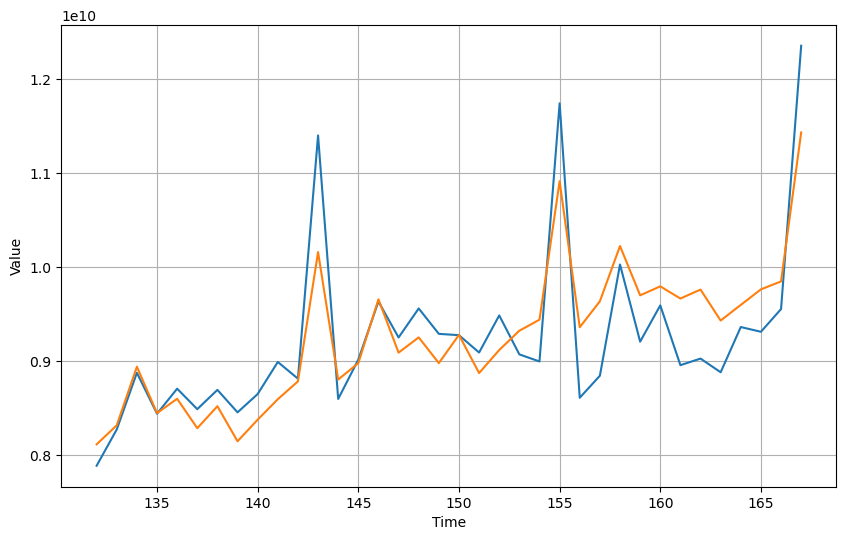

In [76]:
# SARIMAX DNN average
dnn_sarimax = np.stack((dnn_test_pred, sarimax_test_pred))
dnn_sarimax_ave_test_pred = np.mean(dnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_sarimax_ave_test_pred)

In [77]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))

DNN MAPE:
0.042051256440442636
SARIMAX MAPE:
0.03675747575470514
DNN SARIMAX AVERAGE MAPE:
0.036689870214753825


In [78]:
# SARIMAXとDNNの平均は、SARIMAX単体・DNN単体よりもわずかにMAPEが改善した。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でDNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# (DNNはエポック数を極端に増加させれば、季節性を捉えられることは予備実験済み。)
# 変動が小さい時はDNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [96]:
# 月ごとの平均の先月比売上変動率
# average_monthly_volatility：[[1月の先月売上比],[2月の先月売上比],[3月の先月売上比], ....]

volatility_list = []
for time in range(len(x_train)-24):
    volatility_list.append(x_train[time+12] / x_train[time+11])

variable_ratio = np.array(volatility_list).reshape(9, -1).T
average_monthly_volatility = np.mean(variable_ratio, axis=-1)
average_monthly_volatility

array([0.73621667, 1.03861041, 1.07980835, 0.9419914 , 1.03286418,
       0.96690145, 0.98699062, 0.96551893, 1.01983994, 1.05136349,
       1.03029797, 1.30995599])

In [97]:
# (変動率 - 1)の絶対値    (先月に比べて変動のしやすさのスコア)
a = np.abs(average_monthly_volatility-1)
a

array([0.26378333, 0.03861041, 0.07980835, 0.0580086 , 0.03286418,
       0.03309855, 0.01300938, 0.03448107, 0.01983994, 0.05136349,
       0.03029797, 0.30995599])

In [98]:
# 変動のし易さの偏差値/100
# 0.5未満のとき、他の月と比べて変動しにくい
# 0.5以上のとき、他の月と比べて変動しやすい
b = np.array((50.0+10.0*(a-np.average(a))/np.std(a))/100)
b = np.ravel(np.repeat(b[None, :], 3, axis=0))                # 予想が3年分あるため
b

array([0.69441085, 0.45566259, 0.49934429, 0.47623027, 0.44956993,
       0.44981843, 0.42851812, 0.4512843 , 0.43576047, 0.46918454,
       0.44684901, 0.74336719, 0.69441085, 0.45566259, 0.49934429,
       0.47623027, 0.44956993, 0.44981843, 0.42851812, 0.4512843 ,
       0.43576047, 0.46918454, 0.44684901, 0.74336719, 0.69441085,
       0.45566259, 0.49934429, 0.47623027, 0.44956993, 0.44981843,
       0.42851812, 0.4512843 , 0.43576047, 0.46918454, 0.44684901,
       0.74336719])

In [99]:
c = np.array(1-b)
c

array([0.30558915, 0.54433741, 0.50065571, 0.52376973, 0.55043007,
       0.55018157, 0.57148188, 0.5487157 , 0.56423953, 0.53081546,
       0.55315099, 0.25663281, 0.30558915, 0.54433741, 0.50065571,
       0.52376973, 0.55043007, 0.55018157, 0.57148188, 0.5487157 ,
       0.56423953, 0.53081546, 0.55315099, 0.25663281, 0.30558915,
       0.54433741, 0.50065571, 0.52376973, 0.55043007, 0.55018157,
       0.57148188, 0.5487157 , 0.56423953, 0.53081546, 0.55315099,
       0.25663281])

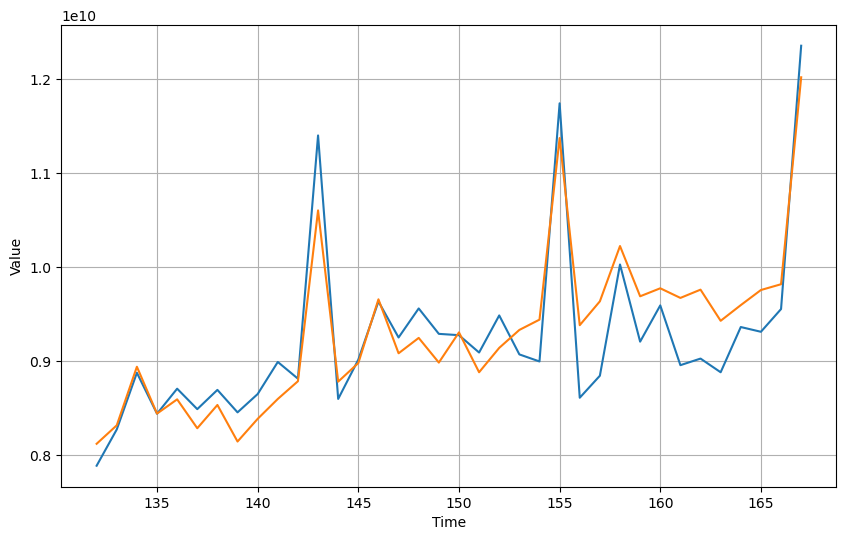

In [116]:
# b*SARIMAX+c*DNN

dnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_deviation_weighted_test_pred)

In [117]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))

DNN MAPE:
0.042051256440442636
SARIMAX MAPE:
0.03675747575470514
DNN SARIMAX Average MAPE:
0.036689870214753825
DNN SARIMAX Deviation weighted MAPE:
0.0329768245831964


In [118]:
# 先月との変動率をもとに重みをつけた場合、MAPEを改善させることができた。

In [119]:
# 移動平均との差から変動の大きさをスコア化する

In [187]:
# 移動平均(12時点から120時点まで)
moving_average = np.array(df_train.Sales.rolling(24).mean().shift(-12).values[12:120])

# 月ごとの実測値と移動平均値との差の平均
diff_moving_average = (x_train[12:120] - moving_average).reshape(9, -1).T
d = np.mean(diff_moving_average, axis=-1)
d

array([-2.80155879e+08, -1.27597979e+08,  2.56213721e+08, -1.19090679e+08,
        3.10712765e+07, -1.87860381e+08, -2.83755082e+08, -4.93293618e+08,
       -4.24293630e+08, -1.90317432e+08, -7.28048737e+07,  1.61912537e+09])

In [188]:
# (実測値と移動平均値の差)の絶対値の偏差値
e = np.array((50.0+10.0*(d-np.average(d))/np.std(d))/100)
e = np.ravel(np.repeat(e[None, :], 3, axis=0))                # 予想が3年分あるため
e

array([0.45143499, 0.48021599, 0.55262446, 0.48182095, 0.51014993,
       0.46884711, 0.45075598, 0.41122523, 0.42424251, 0.46838357,
       0.49055305, 0.80974623, 0.45143499, 0.48021599, 0.55262446,
       0.48182095, 0.51014993, 0.46884711, 0.45075598, 0.41122523,
       0.42424251, 0.46838357, 0.49055305, 0.80974623, 0.45143499,
       0.48021599, 0.55262446, 0.48182095, 0.51014993, 0.46884711,
       0.45075598, 0.41122523, 0.42424251, 0.46838357, 0.49055305,
       0.80974623])

In [189]:
f = np.array(1-e)
f

array([0.54856501, 0.51978401, 0.44737554, 0.51817905, 0.48985007,
       0.53115289, 0.54924402, 0.58877477, 0.57575749, 0.53161643,
       0.50944695, 0.19025377, 0.54856501, 0.51978401, 0.44737554,
       0.51817905, 0.48985007, 0.53115289, 0.54924402, 0.58877477,
       0.57575749, 0.53161643, 0.50944695, 0.19025377, 0.54856501,
       0.51978401, 0.44737554, 0.51817905, 0.48985007, 0.53115289,
       0.54924402, 0.58877477, 0.57575749, 0.53161643, 0.50944695,
       0.19025377])

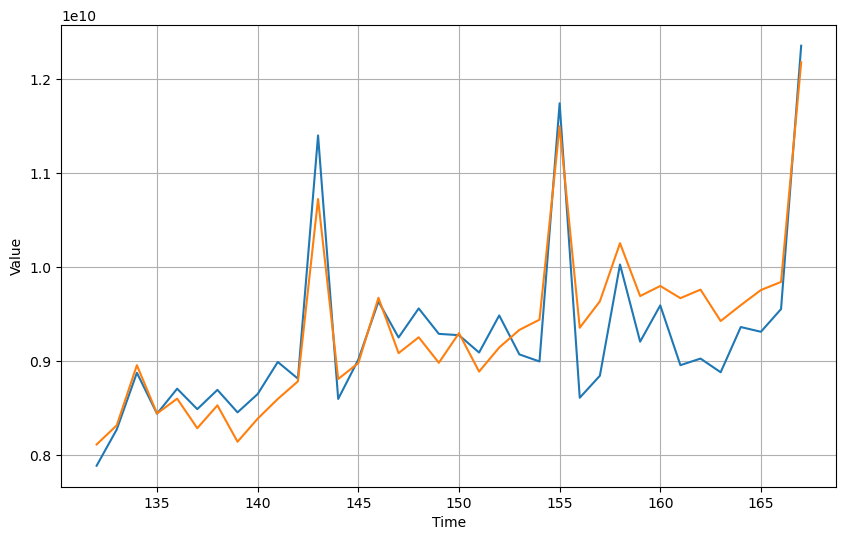

In [190]:
# e*SARIMAX+f*DNN
dnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_diff_moving_average_test_pred)

In [191]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))

DNN MAPE:
0.042051256440442636
SARIMAX MAPE:
0.03675747575470514
DNN SARIMAX Average MAPE:
0.036689870214753825
DNN SARIMAX Deviation weighted MAPE:
0.0329768245831964
DNN SARIMAX Diff Moving Average MAPE:
0.032243434797506604


In [109]:
# DNNでは季節性トレンドの変動を捉えられないため、そこをSARIMAXで補いたい

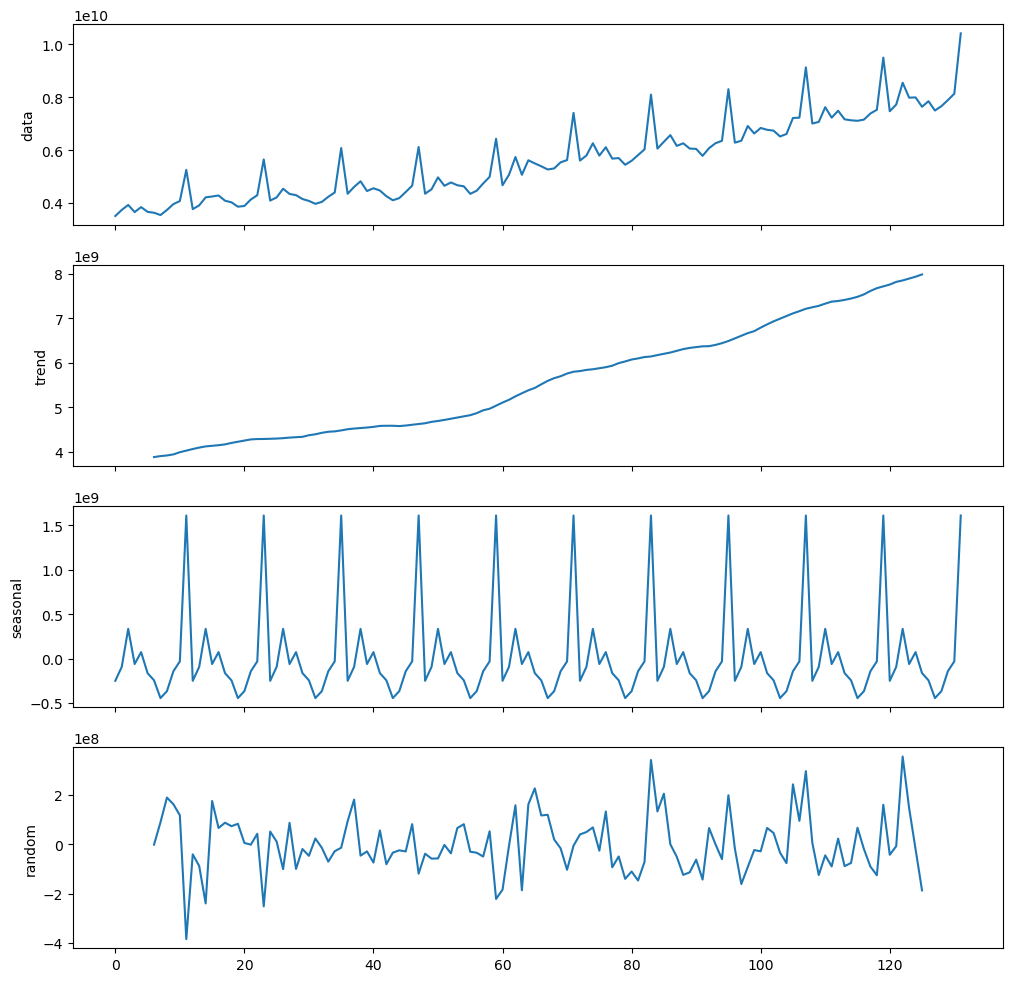

In [110]:
component_decomposition = arima.decompose(df_train.Sales.values,'additive',m=12)
utils.decomposed_plot(component_decomposition, figure_kwargs = {'figsize': (12, 12)})

In [192]:
# 季節性トレンドの絶対値
seasonal = np.array(component_decomposition.seasonal[12:24])
seasonal

array([-2.49905375e+08, -9.27866298e+07,  3.35564313e+08, -6.08086195e+07,
        7.32262340e+07, -1.63605941e+08, -2.44321736e+08, -4.44731348e+08,
       -3.66585282e+08, -1.42452898e+08, -3.07804457e+07,  1.61271243e+09])

In [193]:
# (実測値と移動平均値の差)の絶対値の偏差値
g = np.array((50.0+10.0*(seasonal-np.average(seasonal))/np.std(seasonal))/100)
g = np.ravel(np.repeat(g[None, :], 3, axis=0))                # 予想が4年分あるため
g

array([0.44820243, 0.47849047, 0.56106439, 0.48465492, 0.51049305,
       0.46483851, 0.44927879, 0.4106455 , 0.42570985, 0.46891622,
       0.4904435 , 0.80726237, 0.44820243, 0.47849047, 0.56106439,
       0.48465492, 0.51049305, 0.46483851, 0.44927879, 0.4106455 ,
       0.42570985, 0.46891622, 0.4904435 , 0.80726237, 0.44820243,
       0.47849047, 0.56106439, 0.48465492, 0.51049305, 0.46483851,
       0.44927879, 0.4106455 , 0.42570985, 0.46891622, 0.4904435 ,
       0.80726237])

In [194]:
h = np.array(1-g)
h

array([0.55179757, 0.52150953, 0.43893561, 0.51534508, 0.48950695,
       0.53516149, 0.55072121, 0.5893545 , 0.57429015, 0.53108378,
       0.5095565 , 0.19273763, 0.55179757, 0.52150953, 0.43893561,
       0.51534508, 0.48950695, 0.53516149, 0.55072121, 0.5893545 ,
       0.57429015, 0.53108378, 0.5095565 , 0.19273763, 0.55179757,
       0.52150953, 0.43893561, 0.51534508, 0.48950695, 0.53516149,
       0.55072121, 0.5893545 , 0.57429015, 0.53108378, 0.5095565 ,
       0.19273763])

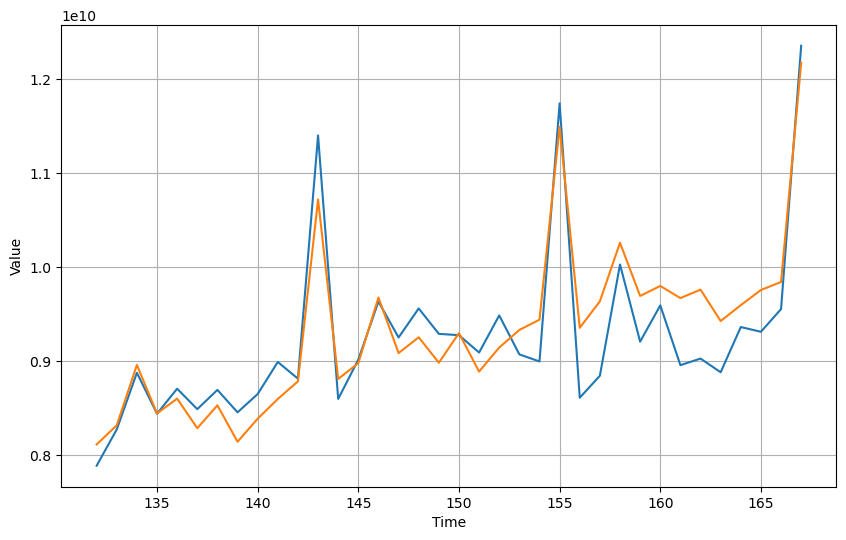

In [195]:
# g*SARIMAX+h*DNN
dnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_seasonal_trend_test_pred)

In [196]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))
print('DNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_seasonal_trend_test_pred))

DNN MAPE:
0.042051256440442636
SARIMAX MAPE:
0.03675747575470514
DNN SARIMAX Average MAPE:
0.036689870214753825
DNN SARIMAX Deviation weighted MAPE:
0.0329768245831964
DNN SARIMAX Diff Moving Average MAPE:
0.032243434797506604
DNN SARIMAX Seasonal Trend MAPE:
0.03231422211804043


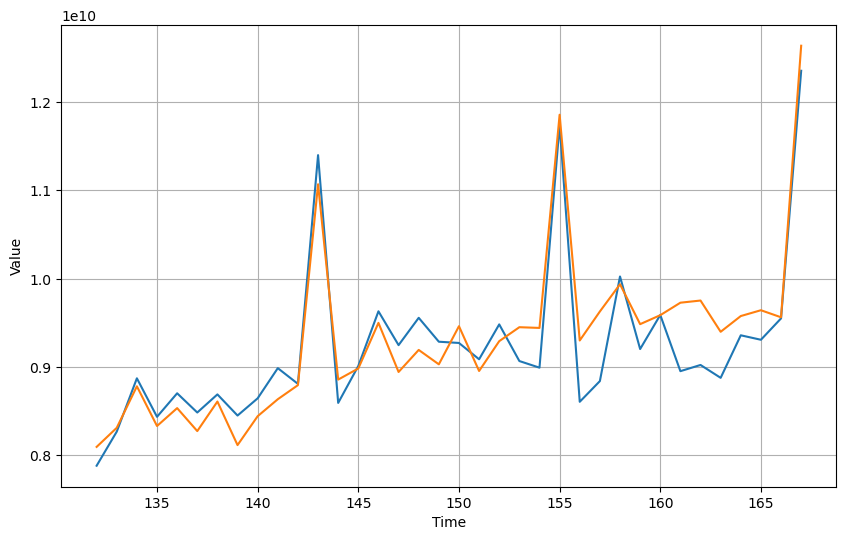

In [197]:
# 単純に12月だけSARIMAX、それ以外をDNNとしてやってみる

# sarimaxの12月の各値
sarimax_test_pred_12 = np.array(sarimax_test_pred).reshape(3,12)[:,11].reshape(3,1)

# DNNの12月以外の各値
dnn_test_pred_1_11 = dnn_test_pred.reshape(3,12)[:, 0:11]

# 1月-11月がDNN , 12月がSARIMAX
dnn_1_11_sarimax_12_test_pred =np.ravel(np.append(dnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_1_11_sarimax_12_test_pred)

In [198]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))
print('DNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_seasonal_trend_test_pred))
print('DNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_1_11_sarimax_12_test_pred))

DNN MAPE:
0.042051256440442636
SARIMAX MAPE:
0.03675747575470514
DNN SARIMAX Average MAPE:
0.036689870214753825
DNN SARIMAX Deviation weighted MAPE:
0.0329768245831964
DNN SARIMAX Diff Moving Average MAPE:
0.032243434797506604
DNN SARIMAX Seasonal Trend MAPE:
0.03231422211804043
DNN 1-11 SARIMAX 12 MAPE:
0.029528232697900243


In [136]:
# 12月だけSARIMAXにするのは恣意的だと思うが、一番良いMAPEを得ることができた。

In [79]:
# CNN

In [80]:
# 畳み込みのコード化

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [82]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [81]:
# filters・・・学習させたいフィルタの数。この数のフィルタを生成し、データに会うように時間をかけて学習する。
# kernel_size・・・フィルタの大きさ。
# strides・・・フィルタがリストをスキャンする際のステップの大きさ。通常は1。
# padding・・・リストのどちらの端からデータをドロップするかを決定する。
# activatoin・・・活性化関数。reluは層から出てくる負の値を効果的に排除することを意味する。
# input_shape・・・ネットワークに渡す入力データの形状。ここでは最初の層のため指定する必要がある。

from tensorflow.keras.layers import Conv1D

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 80ms/step - loss: 82.5243
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 27.2477
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 14.4346
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 12.9783
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 12.8709
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 12.6923
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 12.6111
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 12.6624
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 12.3797
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 12.2775
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 12.2385
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 12.0298
Epoch 13/500
4/4 [==============================] - 0s 3ms

4/4 [==============================] - 0s 5ms/step - loss: 8.3978
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 8.1771
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 8.2906
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 8.1459
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 8.2646
Epoch 211/500
4/4 [==============================] - 0s 7ms/step - loss: 8.1111
Epoch 212/500
4/4 [==============================] - 0s 4ms/step - loss: 8.1533
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 8.2231
Epoch 214/500
4/4 [==============================] - 0s 6ms/step - loss: 8.2769
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 8.3401
Epoch 216/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4187
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 8.3462
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 6ms/step - loss: 7.7379
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 7.9383
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7587
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 7.7082
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 7.6698
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9635
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 7.9844
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7378
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7380
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 7.8669
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9013
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7195
Epoch 422/500
4/4 [==============================] - 0

5/5 [==============================] - 0s 13ms/step


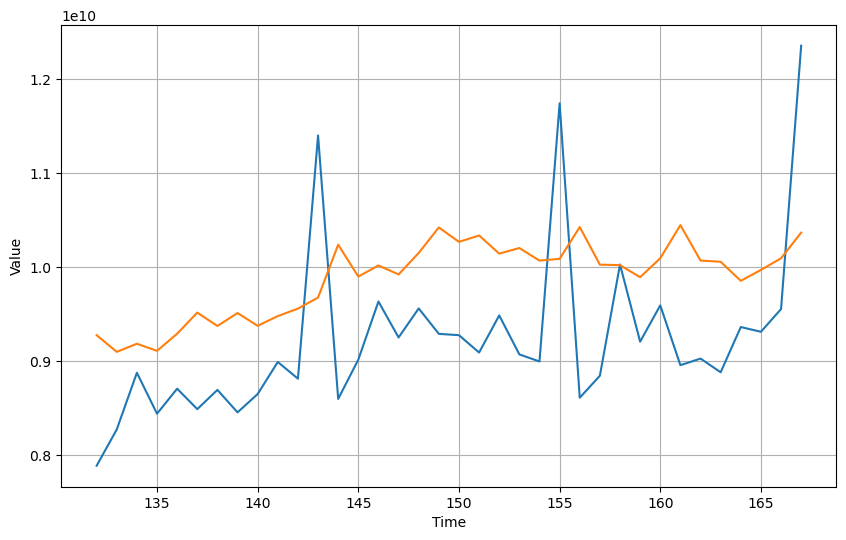

In [83]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [85]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, results))

MAPE:
0.10191802696051683


In [84]:
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=1)

Epoch 1/500
4/4 [==============================] - 3s 23ms/step - loss: 104.8380 - lr: 1.0000e-08
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 104.8377 - lr: 1.1220e-08
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 104.8370 - lr: 1.2589e-08
Epoch 4/500
4/4 [==============================] - 0s 27ms/step - loss: 104.8360 - lr: 1.4125e-08
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 104.8348 - lr: 1.5849e-08
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 104.8334 - lr: 1.7783e-08
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 104.8318 - lr: 1.9953e-08
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 104.8300 - lr: 2.2387e-08
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 104.8278 - lr: 2.5119e-08
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 104.8255 - lr: 2.8184e-08
Epoch 11/500
4/4 [========

Epoch 170/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 2.8184
Epoch 171/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 3.1623
Epoch 172/500
4/4 [==============================] - 0s 8ms/step - loss: 100.0000 - lr: 3.5481
Epoch 173/500
4/4 [==============================] - 0s 3ms/step - loss: 100.0000 - lr: 3.9811
Epoch 174/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 4.4668
Epoch 175/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 5.0119
Epoch 176/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 5.6234
Epoch 177/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 6.3096
Epoch 178/500
4/4 [==============================] - 0s 12ms/step - loss: 100.0000 - lr: 7.0795
Epoch 179/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 7.9433
Epoch 180/500
4/4 [==============================

4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 501187232.0000
Epoch 336/500
4/4 [==============================] - 0s 3ms/step - loss: 100.0000 - lr: 562341312.0000
Epoch 337/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 630957376.0000
Epoch 338/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 707945792.0000
Epoch 339/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9999 - lr: 794328256.0000
Epoch 340/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 891250944.0000
Epoch 341/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1000000000.0000
Epoch 342/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1122018432.0000
Epoch 343/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1258925440.0000
Epoch 344/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1412

Epoch 414/500
4/4 [==============================] - 0s 5ms/step - loss: 99.6187 - lr: 4466835718144.0000
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 99.5722 - lr: 5011872415744.0000
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 99.5205 - lr: 5623413473280.0000
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 99.4615 - lr: 6309573296128.0000
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 99.3962 - lr: 7079457718272.0000
Epoch 419/500
4/4 [==============================] - 0s 4ms/step - loss: 99.3224 - lr: 7943282491392.0000
Epoch 420/500
4/4 [==============================] - 0s 7ms/step - loss: 99.2394 - lr: 8912509075456.0000
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 99.1456 - lr: 9999999827968.0000
Epoch 422/500
4/4 [==============================] - 0s 4ms/step - loss: 99.0427 - lr: 11220184727552.0000
Epoch 423/500
4/4 [==========================

Epoch 490/500
4/4 [==============================] - 0s 5ms/step - loss: 20.4633 - lr: 28183828799422464.0000
Epoch 491/500
4/4 [==============================] - 0s 7ms/step - loss: 19.7295 - lr: 31622776901074944.0000
Epoch 492/500
4/4 [==============================] - 0s 4ms/step - loss: 19.5625 - lr: 35481339012579328.0000
Epoch 493/500
4/4 [==============================] - 0s 8ms/step - loss: 20.4200 - lr: 39810717586554880.0000
Epoch 494/500
4/4 [==============================] - 0s 8ms/step - loss: 19.9654 - lr: 44668359958069248.0000
Epoch 495/500
4/4 [==============================] - 0s 5ms/step - loss: 20.4600 - lr: 50118724996300800.0000
Epoch 496/500
4/4 [==============================] - 0s 4ms/step - loss: 19.5408 - lr: 56234131360579584.0000
Epoch 497/500
4/4 [==============================] - 0s 4ms/step - loss: 19.7759 - lr: 63095732457963520.0000
Epoch 498/500
4/4 [==============================] - 0s 5ms/step - loss: 20.5969 - lr: 70794577300160512.0000
Epoch 499/

(1e-08, 0.001, 0.0, 300.0)

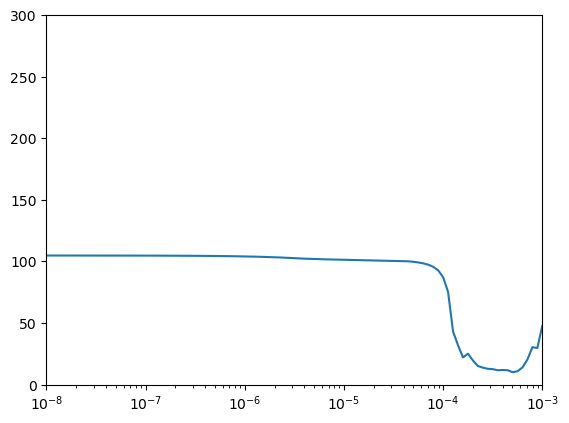

In [86]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [87]:
# MAPEが最小になる学習率は10^-3から10^-4あたり

In [88]:
%%time
# keras tunerでパラメータを探索
# split_by_132/CNN_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding=hp.Choice('padding', ['causal', 'valid', 'same']),
                                   activation='relu', input_shape=[None, 1]))

  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=100, executions_per_trial=3, directory='split_by_132', project_name='CNN_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 100 Complete [00h 01m 13s]
loss: 6.5497487386067705

Best loss So Far: 6.2234171231587725
Total elapsed time: 03h 34m 37s
INFO:tensorflow:Oracle triggered exit
CPU times: user 2h 29min 20s, sys: 21min 3s, total: 2h 50min 23s
Wall time: 3h 34min 37s


In [89]:
tuner.results_summary()

Results summary
Results in split_by_132/CNN_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 10
units2: 22
momentum: 0.9
Score: 6.2234171231587725
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
padding: valid
units1: 10
units2: 6
momentum: 0.5
Score: 6.226814270019531
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
padding: valid
units1: 26
units2: 10
momentum: 0.7
Score: 6.236651102701823
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 18
units2: 14
momentum: 0.7
Score: 6.238162835439046
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 14
units2: 30
momentum: 0.5
Score: 6.256371021270752
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
padding: valid
units1: 10
units2: 18
momentum: 0.9
Score: 6.26002295811971
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
padding: valid
units1: 18
un

In [91]:
from tensorflow.keras.layers import Conv1D

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=192, kernel_size=9, strides=2, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 9ms/step - loss: 98.1790
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 87.7351
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 63.7646
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 22.1742
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 25.1314
Epoch 6/500
4/4 [==============================] - 0s 20ms/step - loss: 22.2582
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 13.7618
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 11.7008
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 9.8763
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 8.2961
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5350
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 9.9914
Epoch 13/500
4/4 [==============================] - 

4/4 [==============================] - 0s 5ms/step - loss: 7.2132
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 7.8892
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9652
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 7.7439
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 7.2396
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9931
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2404
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4112
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0325
Epoch 215/500
4/4 [==============================] - 0s 2ms/step - loss: 6.8520
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7909
Epoch 217/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5870
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 6.8967
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8903
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9260
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 6.6696
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 7.0374
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8619
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 6.8538
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 7.3113
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 6.7037
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 6.5817
Epoch 420/500
4/4 [==============================] - 0s 3ms/step - loss: 6.8209
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9912
Epoch 422/500
4/4 [==============================] - 0

5/5 [==============================] - 0s 10ms/step


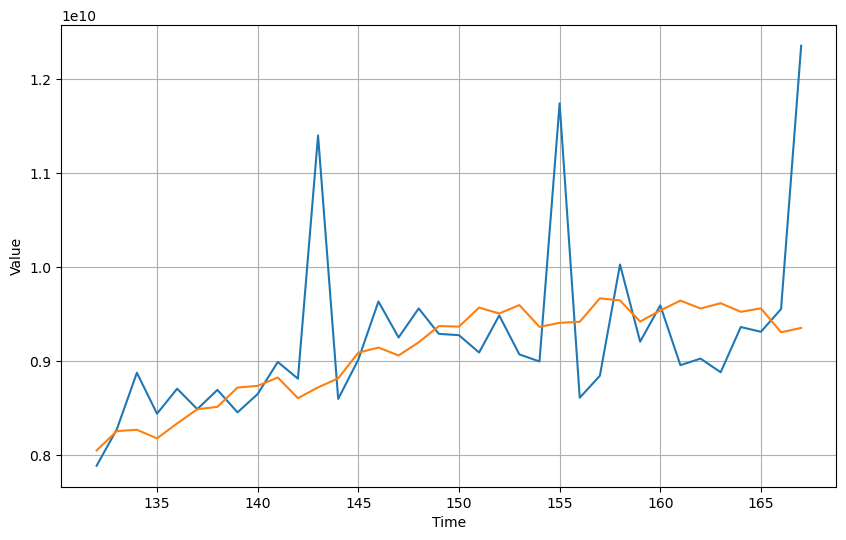

In [92]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [93]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, results))

MAPE:
0.050131179217252596


In [124]:
cnn_forecast = forecast
cnn_test_pred = results

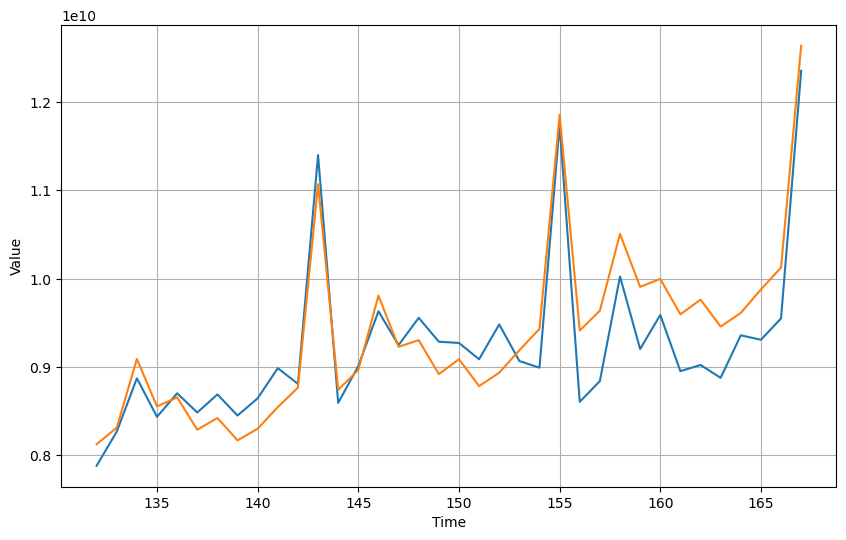

In [125]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

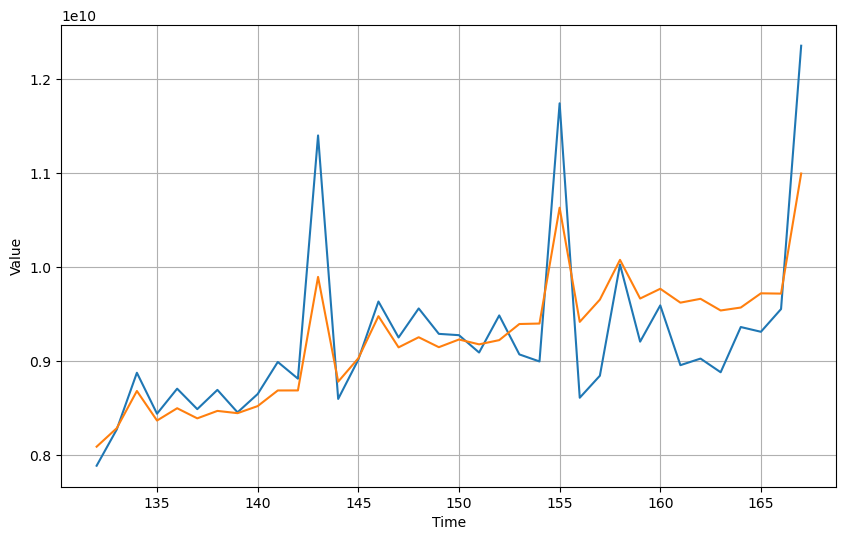

In [126]:
# SARIMAX CNN average
cnn_sarimax = np.stack((cnn_test_pred, sarimax_test_pred))
cnn_sarimax_ave_test_pred = np.mean(cnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_sarimax_ave_test_pred)

In [127]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))

CNN MAPE:
0.050131179217252596
SARIMAX MAPE:
0.03675747575470514
CNN SARIMAX AVERAGE MAPE:
0.03615486432886502


In [128]:
# SARIMAXとCNNの平均のMAPEは、CNN・SARIMAX単体よりも改善した。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でCNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# 変動が小さい時はCNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [129]:
# DNNの時のようにCNNとSARIMAXに重みをつけていく

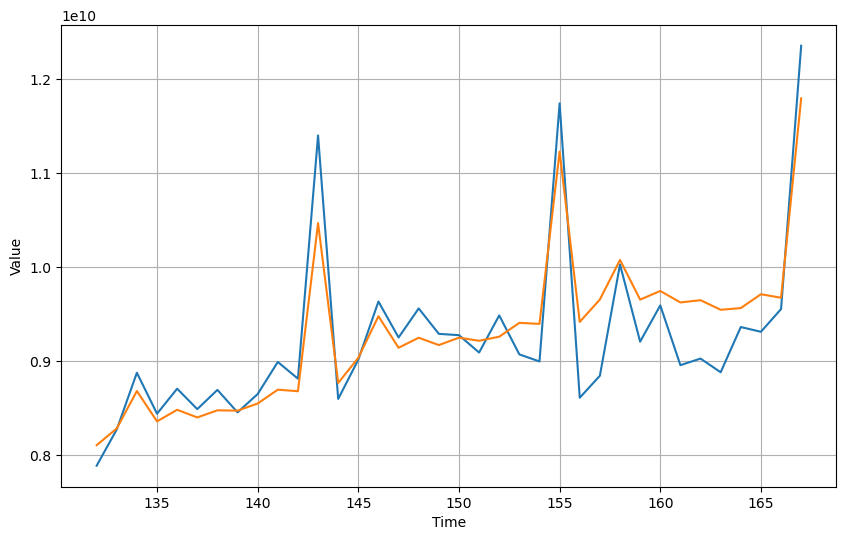

In [130]:
# b*SARIMAX+c*CNN

cnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_deviation_weighted_test_pred)

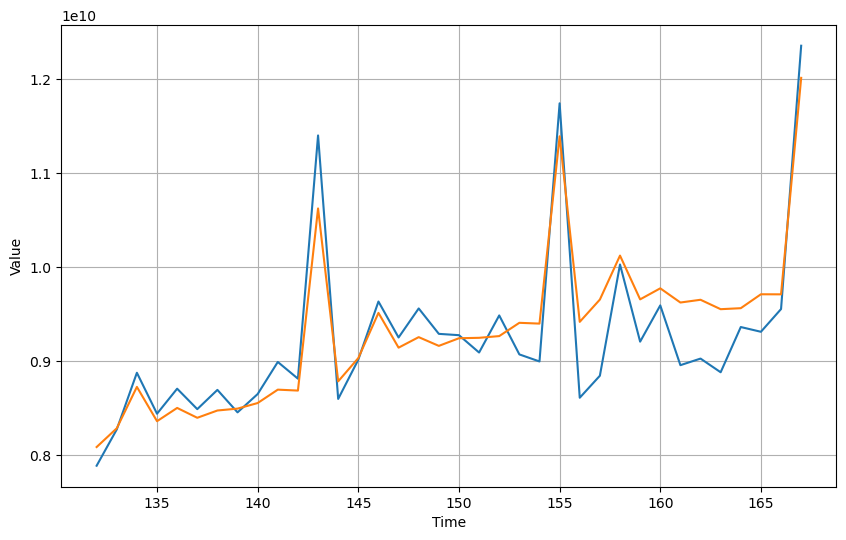

In [199]:
# e*SARIMAX+f*CNN
cnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_diff_moving_average_test_pred)

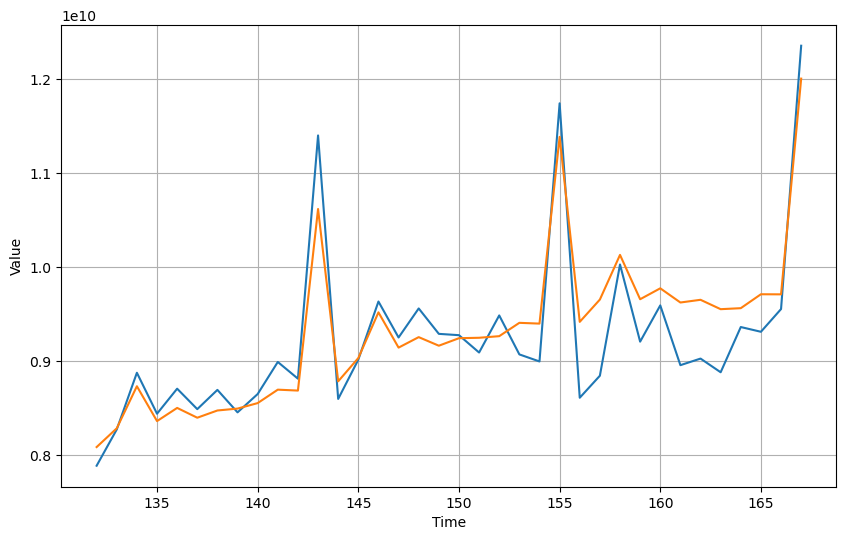

In [200]:
# g*SARIMAX+h*DNN
cnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_seasonal_trend_test_pred)

In [202]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))
print('CNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_deviation_weighted_test_pred))
print('CNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_diff_moving_average_test_pred))
print('CNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_seasonal_trend_test_pred))

CNN MAPE:
0.050131179217252596
SARIMAX MAPE:
0.03675747575470514
CNN SARIMAX Average MAPE:
0.03615486432886502
CNN SARIMAX Deviation weighted MAPE:
0.03119004947936982
CNN SARIMAX Diff Moving Average MAPE:
0.030114861354186125
CNN SARIMAX Seasonal Trend MAPE:
0.03014113902051046


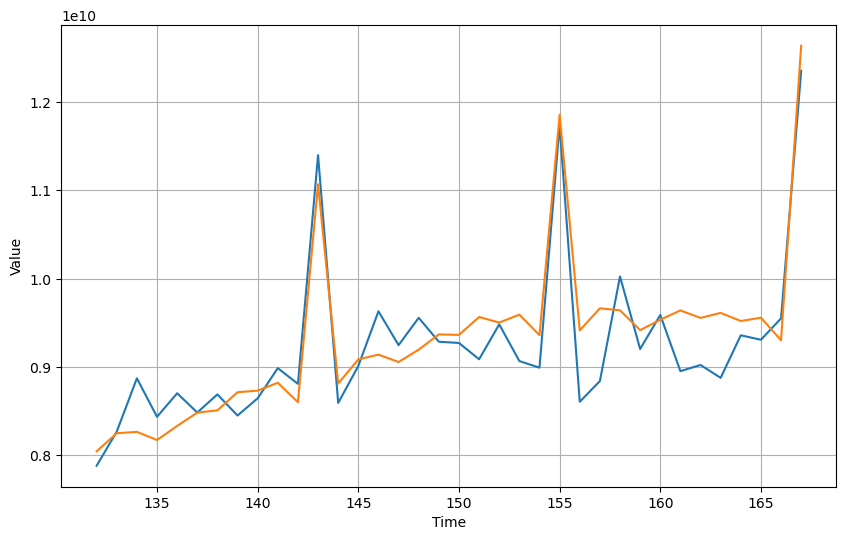

In [137]:
# 単純に12月だけSARIMAX、それ以外をCNNとしてやってみる

# CNNの12月以外の各値
cnn_test_pred_1_11 = cnn_test_pred.reshape(3,12)[:, 0:11]

# 1月-11月がDNN , 12月がSARIMAX
cnn_1_11_sarimax_12_test_pred =np.ravel(np.append(cnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_1_11_sarimax_12_test_pred)

In [201]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))
print('CNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_deviation_weighted_test_pred))
print('CNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_diff_moving_average_test_pred))
print('CNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_seasonal_trend_test_pred))
print('CNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_1_11_sarimax_12_test_pred))

CNN MAPE:
0.050131179217252596
SARIMAX MAPE:
0.03675747575470514
CNN SARIMAX Average MAPE:
0.03615486432886502
CNN SARIMAX Deviation weighted MAPE:
0.03119004947936982
CNN SARIMAX Diff Moving Average MAPE:
0.030114861354186125
CNN SARIMAX Seasonal Trend MAPE:
0.03014113902051046
CNN 1-11 SARIMAX 12 MAPE:
0.03302496796285729


In [139]:
# RNN

In [140]:
from tensorflow.keras.layers import SimpleRNN

In [150]:
%%time
# 学習率の大まかなエリアを絞り込む
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=True, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 36.6 s, sys: 4.57 s, total: 41.2 s
Wall time: 37.2 s


(1e-08, 0.001, 0.0, 300.0)

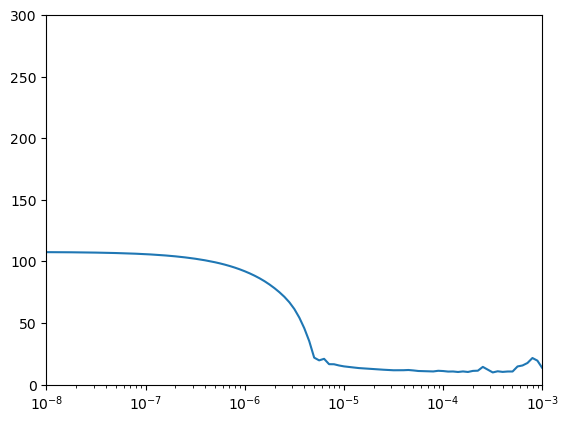

In [151]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [145]:
# MAPEは学習率が10^-4くらいで最小となる

In [154]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=True, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 5s 21ms/step - loss: 72.2309
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 34.4261
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 16.2264
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 14.7756
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 14.2036
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 13.8072
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 13.6657
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 13.2112
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 12.9284
Epoch 10/500
4/4 [==============================] - 0s 10ms/step - loss: 12.7119
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 12.5968
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 12.3146
Epoch 13/500
4/4 [==========================

4/4 [==============================] - 0s 7ms/step - loss: 8.4505
Epoch 206/500
4/4 [==============================] - 0s 7ms/step - loss: 8.3561
Epoch 207/500
4/4 [==============================] - 0s 9ms/step - loss: 8.6338
Epoch 208/500
4/4 [==============================] - 0s 9ms/step - loss: 8.3951
Epoch 209/500
4/4 [==============================] - 0s 9ms/step - loss: 8.7578
Epoch 210/500
4/4 [==============================] - 0s 8ms/step - loss: 8.3769
Epoch 211/500
4/4 [==============================] - 0s 8ms/step - loss: 8.7293
Epoch 212/500
4/4 [==============================] - 0s 10ms/step - loss: 8.6409
Epoch 213/500
4/4 [==============================] - 0s 9ms/step - loss: 8.4126
Epoch 214/500
4/4 [==============================] - 0s 8ms/step - loss: 8.3501
Epoch 215/500
4/4 [==============================] - 0s 10ms/step - loss: 8.4672
Epoch 216/500
4/4 [==============================] - 0s 8ms/step - loss: 8.3646
Epoch 217/500
4/4 [==============================] -

4/4 [==============================] - 0s 8ms/step - loss: 7.7427
Epoch 410/500
4/4 [==============================] - 0s 9ms/step - loss: 7.4742
Epoch 411/500
4/4 [==============================] - 0s 9ms/step - loss: 7.7051
Epoch 412/500
4/4 [==============================] - 0s 9ms/step - loss: 7.8022
Epoch 413/500
4/4 [==============================] - 0s 12ms/step - loss: 7.8911
Epoch 414/500
4/4 [==============================] - 0s 7ms/step - loss: 7.4036
Epoch 415/500
4/4 [==============================] - 0s 7ms/step - loss: 7.7757
Epoch 416/500
4/4 [==============================] - 0s 7ms/step - loss: 8.1690
Epoch 417/500
4/4 [==============================] - 0s 9ms/step - loss: 7.4795
Epoch 418/500
4/4 [==============================] - 0s 9ms/step - loss: 7.7653
Epoch 419/500
4/4 [==============================] - 0s 9ms/step - loss: 8.1938
Epoch 420/500
4/4 [==============================] - 0s 7ms/step - loss: 7.7611
Epoch 421/500
4/4 [==============================] - 

1/1 [==============================] - 0s 17ms/step


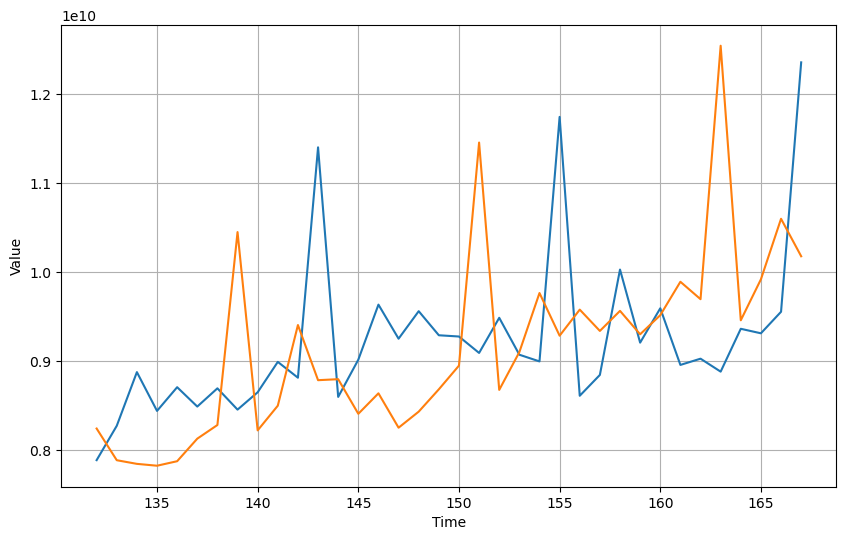

In [155]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [148]:
# やっぱりピークが微妙

In [156]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 2s 71ms/step - loss: 96.8673
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 85.6635
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 64.5126
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 18.3037
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 18.7485
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 11.7641
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 13.6464
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 14.3677
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 9.3145
Epoch 10/500
4/4 [==============================] - 0s 8ms/step - loss: 10.6108
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 7.4350
Epoch 12/500
4/4 [==============================] - 0s 8ms/step - loss: 8.7053
Epoch 13/500
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 5.9189
Epoch 105/500
4/4 [==============================] - 0s 7ms/step - loss: 6.1843
Epoch 106/500
4/4 [==============================] - 0s 9ms/step - loss: 6.3225
Epoch 107/500
4/4 [==============================] - 0s 8ms/step - loss: 6.3708
Epoch 108/500
4/4 [==============================] - 0s 9ms/step - loss: 6.1106
Epoch 109/500
4/4 [==============================] - 0s 7ms/step - loss: 5.7360
Epoch 110/500
4/4 [==============================] - 0s 8ms/step - loss: 6.0638
Epoch 111/500
4/4 [==============================] - 0s 8ms/step - loss: 7.3072
Epoch 112/500
4/4 [==============================] - 0s 10ms/step - loss: 6.0082
Epoch 113/500
4/4 [==============================] - 0s 6ms/step - loss: 6.2817
Epoch 114/500
4/4 [==============================] - 0s 10ms/step - loss: 7.1413
Epoch 115/500
4/4 [==============================] - 0s 9ms/step - loss: 6.0417
Epoch 116/500
4/4 [==============================] -

4/4 [==============================] - 0s 9ms/step - loss: 6.0014
Epoch 309/500
4/4 [==============================] - 0s 9ms/step - loss: 5.8759
Epoch 310/500
4/4 [==============================] - 0s 16ms/step - loss: 5.1276
Epoch 311/500
4/4 [==============================] - 0s 8ms/step - loss: 6.0730
Epoch 312/500
4/4 [==============================] - 0s 7ms/step - loss: 6.5603
Epoch 313/500
4/4 [==============================] - 0s 9ms/step - loss: 5.5665
Epoch 314/500
4/4 [==============================] - 0s 10ms/step - loss: 6.0010
Epoch 315/500
4/4 [==============================] - 0s 22ms/step - loss: 5.9523
Epoch 316/500
4/4 [==============================] - 0s 8ms/step - loss: 5.4799
Epoch 317/500
4/4 [==============================] - 0s 9ms/step - loss: 5.5978
Epoch 318/500
4/4 [==============================] - 0s 8ms/step - loss: 5.6077
Epoch 319/500
4/4 [==============================] - 0s 7ms/step - loss: 5.7600
Epoch 320/500
4/4 [==============================] 

1/1 [==============================] - 0s 15ms/step


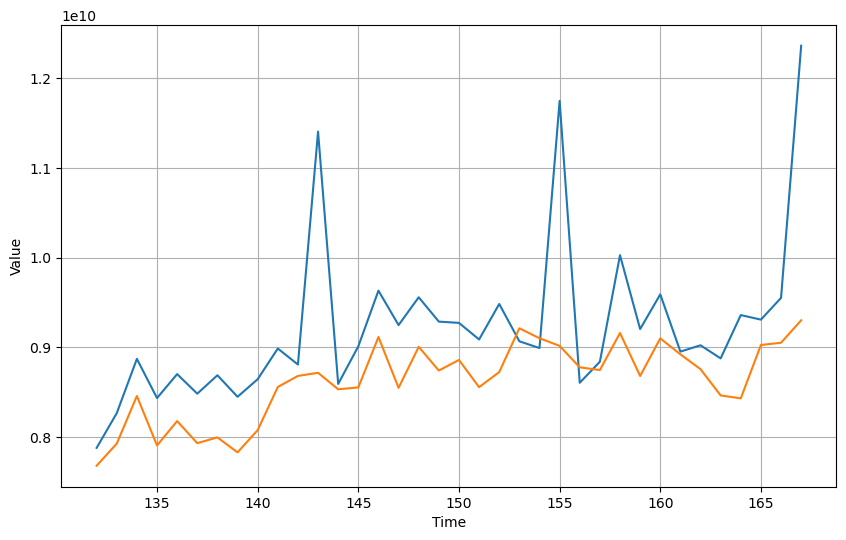

In [157]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [158]:
# ピークは取れないが、return_sequencesをFalseにした方がかなり傾向が掴める

In [159]:
%%time
# return_sequencesをFalseにした時の学習率の大まかなエリアを絞り込む
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 35.9 s, sys: 4.07 s, total: 40 s
Wall time: 37.1 s


(1e-08, 0.001, 0.0, 300.0)

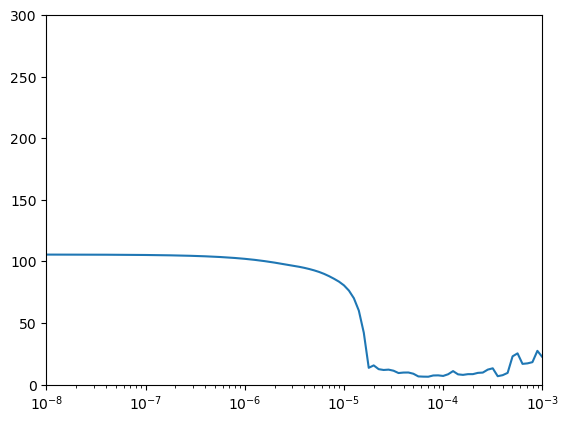

In [160]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [161]:
#この場合でもMAPEは学習率が10^-4から10^-5くらいで最小となる

In [167]:
%%time
# keras tunerでパラメータを探索
# split_by_132/RNN_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = Sequential()
  model.add(SimpleRNN(units=hp.Int('rnn', min_value=20, max_value=200, step=20), input_shape=[None, 1], return_sequences=False, activation='relu'))
  model.add(Dense(units=hp.Int('dense', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_132', project_name='RNN_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 60 Complete [00h 02m 28s]
loss: 36.9417290687561

Best loss So Far: 5.070708433787028
Total elapsed time: 01h 55m 42s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 59min 11s, sys: 15min 9s, total: 2h 14min 21s
Wall time: 1h 55min 42s


In [168]:
tuner.results_summary()

Results summary
Results in split_by_132/RNN_1
Showing 10 best trials
Trial summary
Hyperparameters:
rnn: 160
dense: 22
momentum: 0.5
Score: 5.070708433787028
Trial summary
Hyperparameters:
rnn: 160
dense: 14
momentum: 0.9
Score: 5.077377478281657
Trial summary
Hyperparameters:
rnn: 120
dense: 18
momentum: 0.9
Score: 5.127662022908528
Trial summary
Hyperparameters:
rnn: 120
dense: 26
momentum: 0.5
Score: 5.18304983774821
Trial summary
Hyperparameters:
rnn: 140
dense: 18
momentum: 0.5
Score: 5.234243233998616
Trial summary
Hyperparameters:
rnn: 160
dense: 18
momentum: 0.7
Score: 5.234700361887614
Trial summary
Hyperparameters:
rnn: 60
dense: 18
momentum: 0.5
Score: 5.256619930267334
Trial summary
Hyperparameters:
rnn: 160
dense: 22
momentum: 0.7
Score: 5.278918584187825
Trial summary
Hyperparameters:
rnn: 160
dense: 30
momentum: 0.7
Score: 5.283295472462972
Trial summary
Hyperparameters:
rnn: 200
dense: 10
momentum: 0.5
Score: 5.294374783833821


In [171]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(160, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(22))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 2s 29ms/step - loss: 107.0261
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 100.9458
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 94.2877
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 87.5370
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 80.5333
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 73.1104
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 65.0445
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 56.0104
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 45.6925
Epoch 10/500
4/4 [==============================] - 0s 13ms/step - loss: 33.5091
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 18.9440
Epoch 12/500
4/4 [==============================] - 0s 12ms/step - loss: 6.6917
Epoch 13/500
4/4 [====================

4/4 [==============================] - 0s 11ms/step - loss: 5.2317
Epoch 205/500
4/4 [==============================] - 0s 18ms/step - loss: 5.2608
Epoch 206/500
4/4 [==============================] - 0s 11ms/step - loss: 5.1988
Epoch 207/500
4/4 [==============================] - 0s 9ms/step - loss: 5.2424
Epoch 208/500
4/4 [==============================] - 0s 16ms/step - loss: 5.4156
Epoch 209/500
4/4 [==============================] - 0s 10ms/step - loss: 5.2258
Epoch 210/500
4/4 [==============================] - 0s 12ms/step - loss: 5.1934
Epoch 211/500
4/4 [==============================] - 0s 11ms/step - loss: 5.1655
Epoch 212/500
4/4 [==============================] - 0s 12ms/step - loss: 5.2107
Epoch 213/500
4/4 [==============================] - 0s 16ms/step - loss: 5.1682
Epoch 214/500
4/4 [==============================] - 0s 16ms/step - loss: 5.1708
Epoch 215/500
4/4 [==============================] - 0s 9ms/step - loss: 5.3035
Epoch 216/500
4/4 [=========================

4/4 [==============================] - 0s 28ms/step - loss: 5.0036
Epoch 407/500
4/4 [==============================] - 0s 11ms/step - loss: 5.0229
Epoch 408/500
4/4 [==============================] - 0s 14ms/step - loss: 5.0793
Epoch 409/500
4/4 [==============================] - 0s 23ms/step - loss: 5.1002
Epoch 410/500
4/4 [==============================] - 0s 12ms/step - loss: 5.0349
Epoch 411/500
4/4 [==============================] - 0s 9ms/step - loss: 5.0537
Epoch 412/500
4/4 [==============================] - 0s 7ms/step - loss: 5.0085
Epoch 413/500
4/4 [==============================] - 0s 8ms/step - loss: 4.9873
Epoch 414/500
4/4 [==============================] - 0s 9ms/step - loss: 5.3210
Epoch 415/500
4/4 [==============================] - 0s 13ms/step - loss: 5.3612
Epoch 416/500
4/4 [==============================] - 0s 13ms/step - loss: 5.1439
Epoch 417/500
4/4 [==============================] - 0s 12ms/step - loss: 5.0529
Epoch 418/500
4/4 [===========================

1/1 [==============================] - 0s 18ms/step


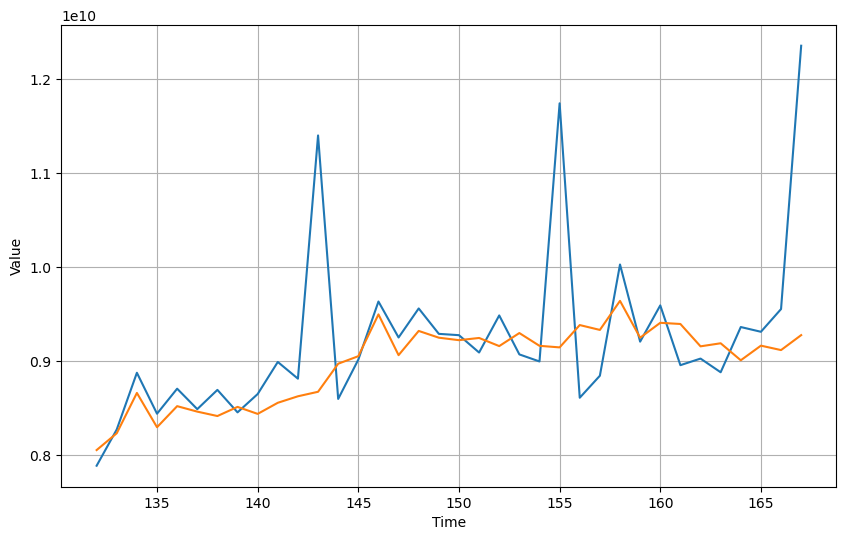

In [172]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [174]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.04312499296302915


In [175]:
rnn_forecast = forecast
rnn_test_pred = test_pred

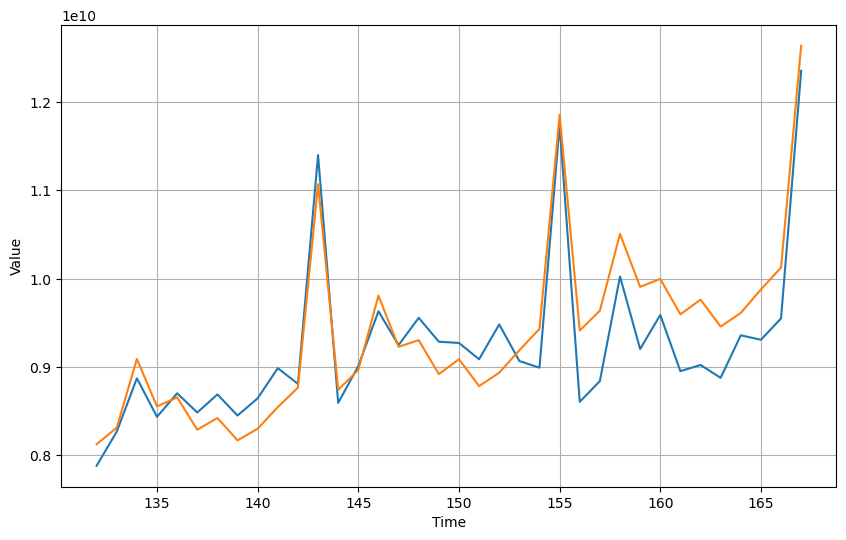

In [176]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

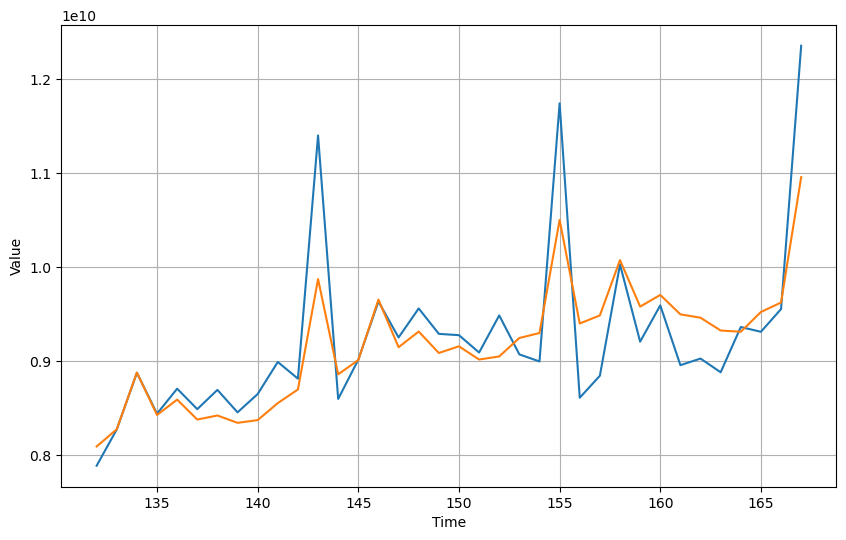

In [177]:
# SARIMAX RNN average
rnn_sarimax = np.stack((rnn_test_pred, sarimax_test_pred))
rnn_sarimax_ave_test_pred = np.mean(rnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_sarimax_ave_test_pred)

In [178]:
# MAPE
print('RNN MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('RNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_sarimax_ave_test_pred))

RNN MAPE:
0.04312499296302915
SARIMAX MAPE:
0.03675747575470514
RNN SARIMAX AVERAGE MAPE:
0.03259319781436895


In [179]:
# SARIMAXとRNNの平均のMAPEは、RNN・SARIMAX単体よりも改善した。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でRNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# 変動が小さい時はRNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [180]:
# DNN・CNNの時のようにRNNとSARIMAXに重みをつけていく

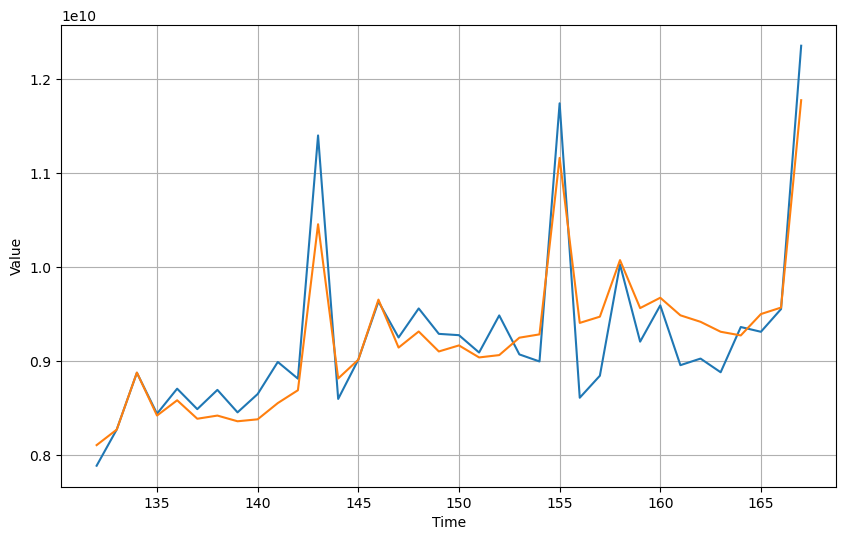

In [181]:
# b*SARIMAX+c*RNN

rnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_deviation_weighted_test_pred)

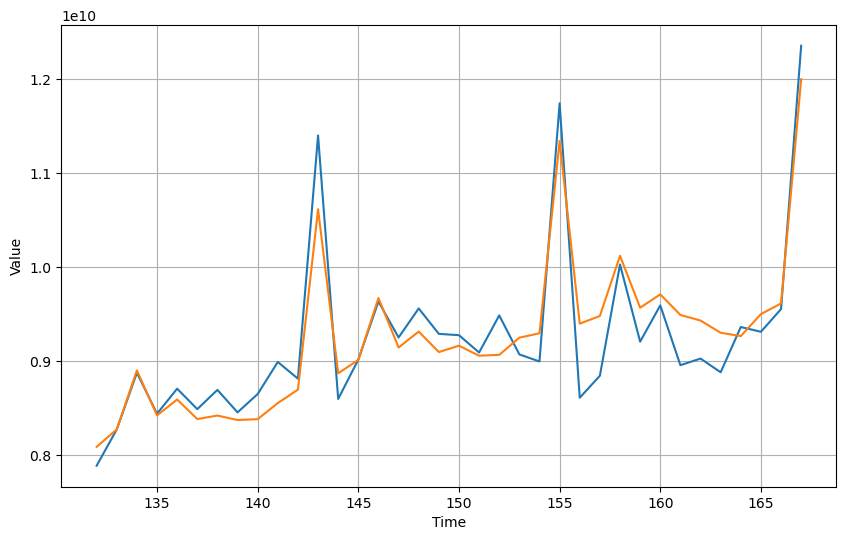

In [203]:
# e*SARIMAX+f*RNN
rnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_diff_moving_average_test_pred)

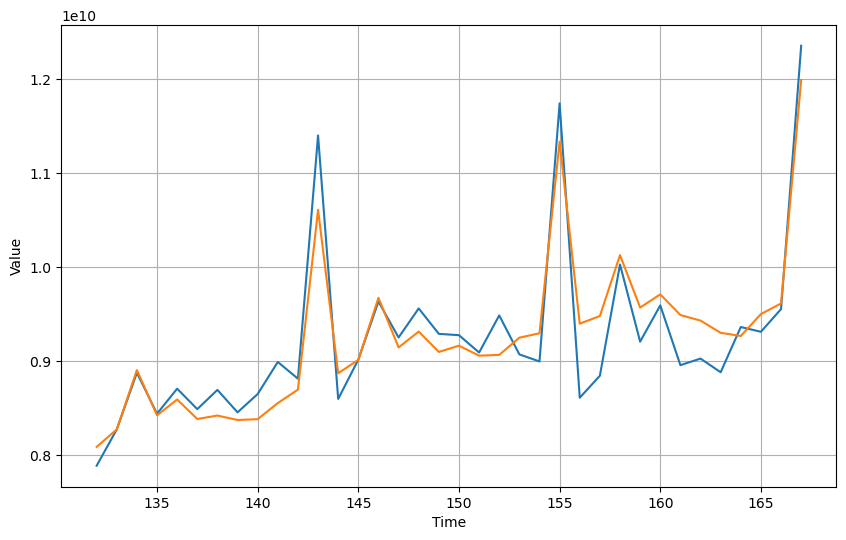

In [204]:
# g*SARIMAX+h*RNN
rnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_seasonal_trend_test_pred)

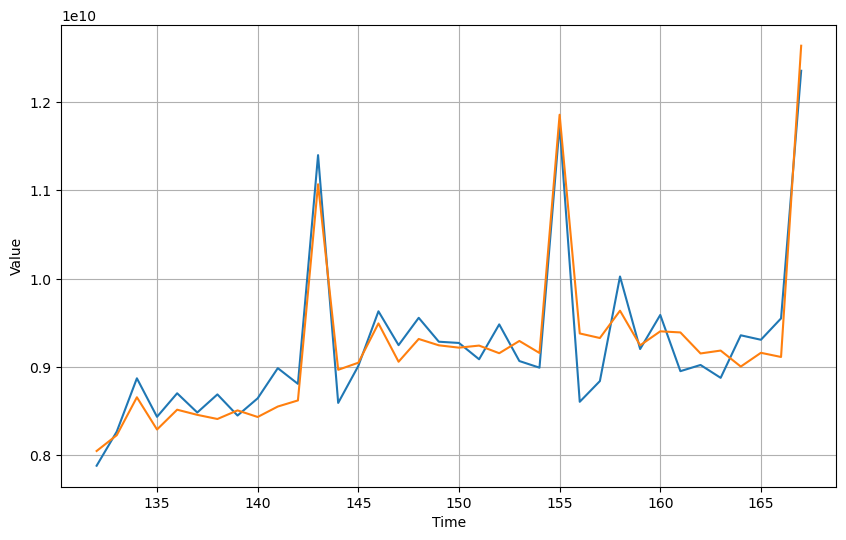

In [205]:
# 単純に12月だけSARIMAX、それ以外をCNNとしてやってみる

# RNNの12月以外の各値
rnn_test_pred_1_11 = rnn_test_pred.reshape(3,12)[:, 0:11]

# 1月-11月がRNN , 12月がSARIMAX
rnn_1_11_sarimax_12_test_pred =np.ravel(np.append(rnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_1_11_sarimax_12_test_pred)

In [206]:
# MAPE
print('RNN MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('RNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_sarimax_ave_test_pred))
print('RNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_deviation_weighted_test_pred))
print('RNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_diff_moving_average_test_pred))
print('RNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_seasonal_trend_test_pred))
print('RNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_1_11_sarimax_12_test_pred))

RNN MAPE:
0.04312499296302915
SARIMAX MAPE:
0.03675747575470514
RNN SARIMAX Average MAPE:
0.03259319781436895
RNN SARIMAX Deviation weighted MAPE:
0.02693796201441118
RNN SARIMAX Diff Moving Average MAPE:
0.026175364005839915
RNN SARIMAX Seasonal Trend MAPE:
0.026250478808342467
RNN 1-11 SARIMAX 12 MAPE:
0.025113686355932148


In [245]:
# CNN2

In [208]:
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 126ms/step - loss: 104.9702 - lr: 1.0000e-08
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 104.9675 - lr: 1.1220e-08
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 104.9627 - lr: 1.2589e-08
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 104.9561 - lr: 1.4125e-08
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 104.9478 - lr: 1.5849e-08
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 104.9380 - lr: 1.7783e-08
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 104.9267 - lr: 1.9953e-08
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 104.9137 - lr: 2.2387e-08
Epoch 9/500
4/4 [==============================] - 0s 14ms/step - loss: 104.8991 - lr: 2.5119e-08
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 104.8825 - lr: 2.8184e-08
Epoch 11/500
4/4 [==================

4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 3.1623
Epoch 172/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 3.5481
Epoch 173/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 3.9811
Epoch 174/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 4.4668
Epoch 175/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 5.0119
Epoch 176/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 5.6234
Epoch 177/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 6.3096
Epoch 178/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 7.0795
Epoch 179/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 7.9433
Epoch 180/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 8.9125
Epoch 181/500
4/4 [==============================] - 0s 6ms/step

4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 562341312.0000
Epoch 337/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 630957376.0000
Epoch 338/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 707945792.0000
Epoch 339/500
4/4 [==============================] - 0s 7ms/step - loss: 99.9999 - lr: 794328256.0000
Epoch 340/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 891250944.0000
Epoch 341/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1000000000.0000
Epoch 342/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 1122018432.0000
Epoch 343/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1258925440.0000
Epoch 344/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1412537600.0000
Epoch 345/500
4/4 [==============================] - 0s 8ms/step - loss: 99.9999 - lr: 1584

Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 99.5721 - lr: 5011872415744.0000
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 99.5192 - lr: 5623413473280.0000
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 99.4606 - lr: 6309573296128.0000
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 99.3950 - lr: 7079457718272.0000
Epoch 419/500
4/4 [==============================] - 0s 7ms/step - loss: 99.3207 - lr: 7943282491392.0000
Epoch 420/500
4/4 [==============================] - 0s 7ms/step - loss: 99.2384 - lr: 8912509075456.0000
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 99.1456 - lr: 9999999827968.0000
Epoch 422/500
4/4 [==============================] - 0s 4ms/step - loss: 99.0410 - lr: 11220184727552.0000
Epoch 423/500
4/4 [==============================] - 0s 4ms/step - loss: 98.9242 - lr: 12589253787648.0000
Epoch 424/500
4/4 [=========================

Epoch 491/500
4/4 [==============================] - 0s 4ms/step - loss: 19.7719 - lr: 31622776901074944.0000
Epoch 492/500
4/4 [==============================] - 0s 4ms/step - loss: 19.7638 - lr: 35481339012579328.0000
Epoch 493/500
4/4 [==============================] - 0s 4ms/step - loss: 19.7369 - lr: 39810717586554880.0000
Epoch 494/500
4/4 [==============================] - 0s 4ms/step - loss: 20.8898 - lr: 44668359958069248.0000
Epoch 495/500
4/4 [==============================] - 0s 3ms/step - loss: 21.1158 - lr: 50118724996300800.0000
Epoch 496/500
4/4 [==============================] - 0s 6ms/step - loss: 19.7482 - lr: 56234131360579584.0000
Epoch 497/500
4/4 [==============================] - 0s 6ms/step - loss: 20.5842 - lr: 63095732457963520.0000
Epoch 498/500
4/4 [==============================] - 0s 6ms/step - loss: 19.9738 - lr: 70794577300160512.0000
Epoch 499/500
4/4 [==============================] - 0s 6ms/step - loss: 20.7634 - lr: 79432825979273216.0000
Epoch 500/

(1e-08, 0.001, 0.0, 300.0)

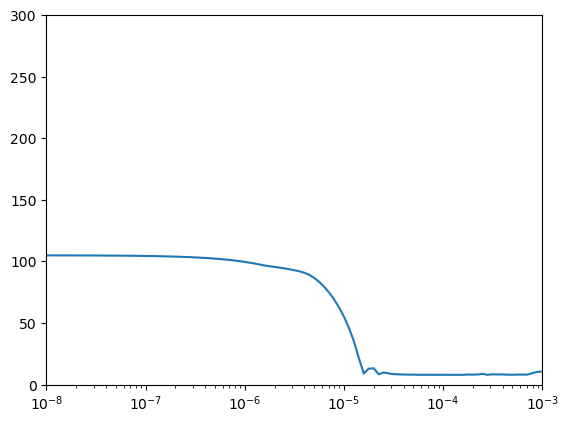

In [209]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [210]:
# MAPEが最小になる学習率は10^-3から10^-4あたり

In [211]:
%%time
# keras tunerでパラメータを探索
# split_by_132/CNN_2

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding=hp.Choice('padding', ['causal', 'valid', 'same']),
                                   activation='relu', input_shape=[None, 1]))

  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_132', project_name='CNN_2')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 60 Complete [00h 01m 57s]
loss: 6.106546719868978

Best loss So Far: 6.106546719868978
Total elapsed time: 02h 05m 47s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 27min 3s, sys: 12min 31s, total: 1h 39min 35s
Wall time: 2h 5min 47s


In [212]:
tuner.results_summary()

Results summary
Results in split_by_132/CNN_2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
padding: valid
units1: 22
momentum: 0.7
Score: 6.106546719868978
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
padding: valid
units1: 14
momentum: 0.9
Score: 6.195027192433675
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
padding: same
units1: 22
momentum: 0.5
Score: 6.4791259765625
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: same
units1: 26
momentum: 0.5
Score: 6.48158057530721
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 3
padding: valid
units1: 30
momentum: 0.9
Score: 6.648447036743164
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
padding: valid
units1: 18
momentum: 0.7
Score: 6.692470868428548
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
padding: valid
units1: 14
momentum: 0.7
Score: 6.727624416351318
Trial summary
Hyperparameters:
un

In [228]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=192, kernel_size=9, strides=3, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(22, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 10ms/step - loss: 89.2804
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 47.4566
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 13.2706
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 8.0221
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 7.1977
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 7.0407
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 6.7722
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 6.5392
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8347
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 6.4731
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 6.6436
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5705
Epoch 13/500
4/4 [==============================] - 0s 6ms/step - los

4/4 [==============================] - 0s 8ms/step - loss: 6.2797
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2756
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5023
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4193
Epoch 210/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2587
Epoch 211/500
4/4 [==============================] - 0s 7ms/step - loss: 6.2596
Epoch 212/500
4/4 [==============================] - 0s 6ms/step - loss: 6.2739
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2951
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 6.2509
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2419
Epoch 216/500
4/4 [==============================] - 0s 6ms/step - loss: 6.2612
Epoch 217/500
4/4 [==============================] - 0s 6ms/step - loss: 6.3000
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 6.4154
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 6.2937
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 6.7031
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 6.5810
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 6.2080
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 6.5049
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2258
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3044
Epoch 419/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3006
Epoch 420/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3110
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1836
Epoch 422/500
4/4 [==============================] - 0s 3ms/step - loss: 6.5867
Epoch 423/500
4/4 [==============================] - 0

5/5 [==============================] - 1s 58ms/step


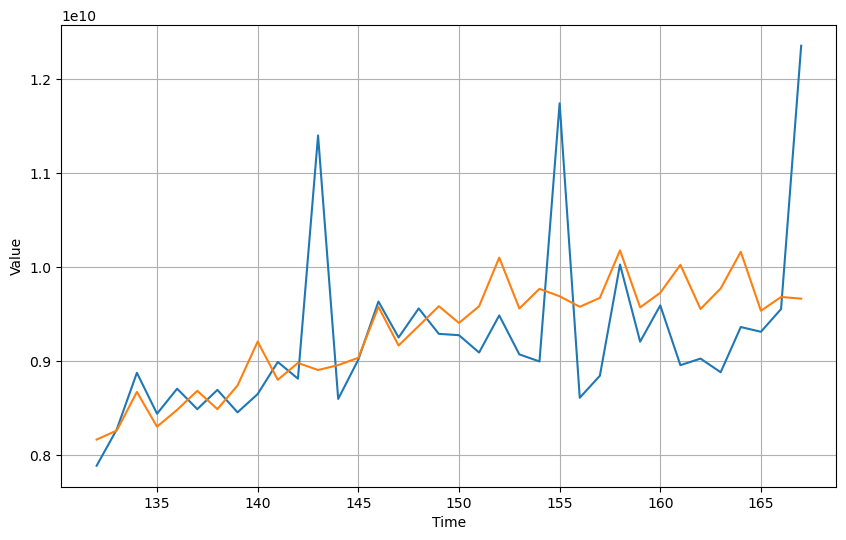

In [232]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [233]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, results))

MAPE:
0.05440686170966142


In [234]:
cnn_forecast_2 = forecast
cnn_test_pred_2 = results

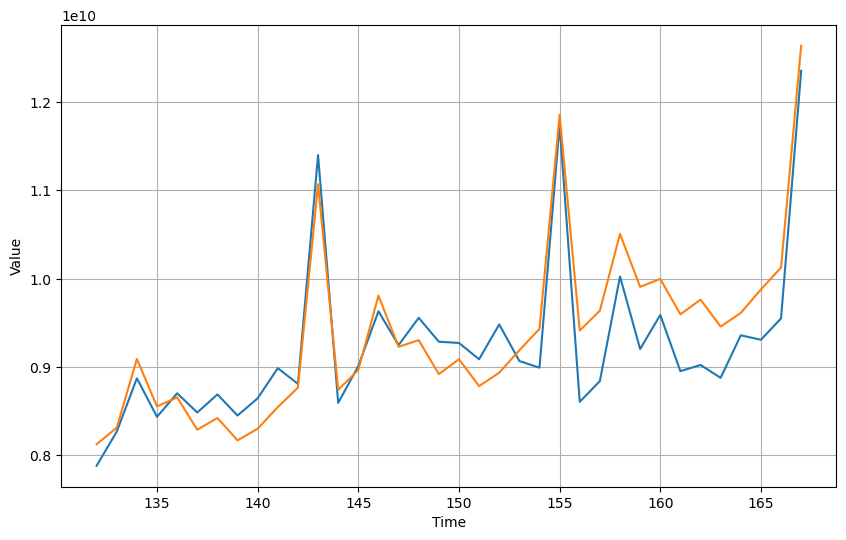

In [235]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

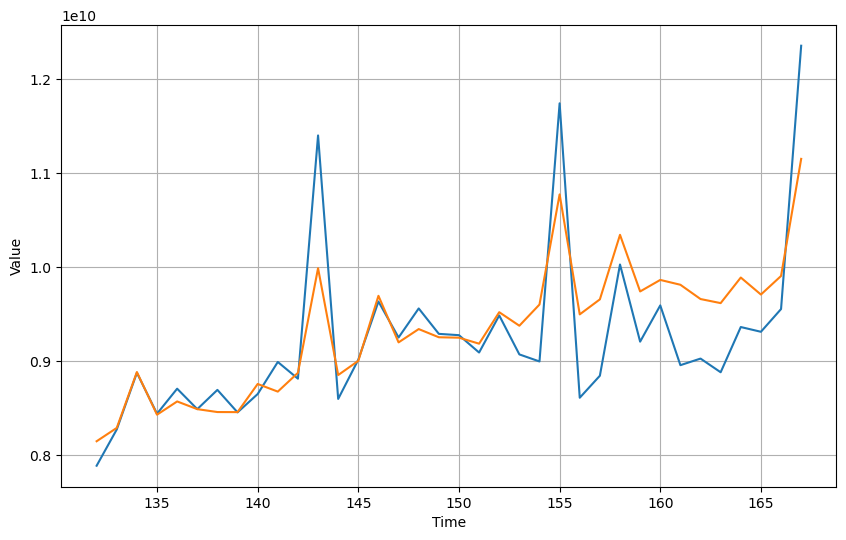

In [236]:
# SARIMAX CNN2 average
cnn_sarimax_2 = np.stack((cnn_test_pred_2, sarimax_test_pred))
cnn_sarimax_ave_test_pred_2 = np.mean(cnn_sarimax_2, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_sarimax_ave_test_pred_2)

In [237]:
# MAPE
print('CNN 2 MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred_2))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN 2 SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred_2))

CNN 2 MAPE:
0.05440686170966142
SARIMAX MAPE:
0.03675747575470514
CNN 2 SARIMAX AVERAGE MAPE:
0.03678098769033453


In [238]:
# SARIMAXとCNN2の平均のMAPEは、CNN2単体よりも改善したが、SARIMAXとはほぼ同じだった。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でCNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# 変動が小さい時はCNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

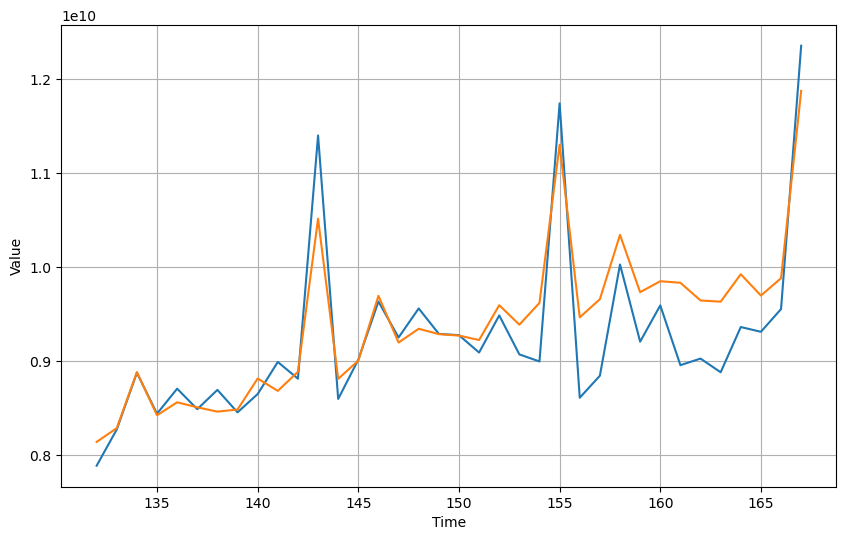

In [239]:
# b*SARIMAX+c*CNN2

cnn_deviation_weighted_test_pred_2 = np.array(b*sarimax_test_pred+c*cnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_deviation_weighted_test_pred_2)

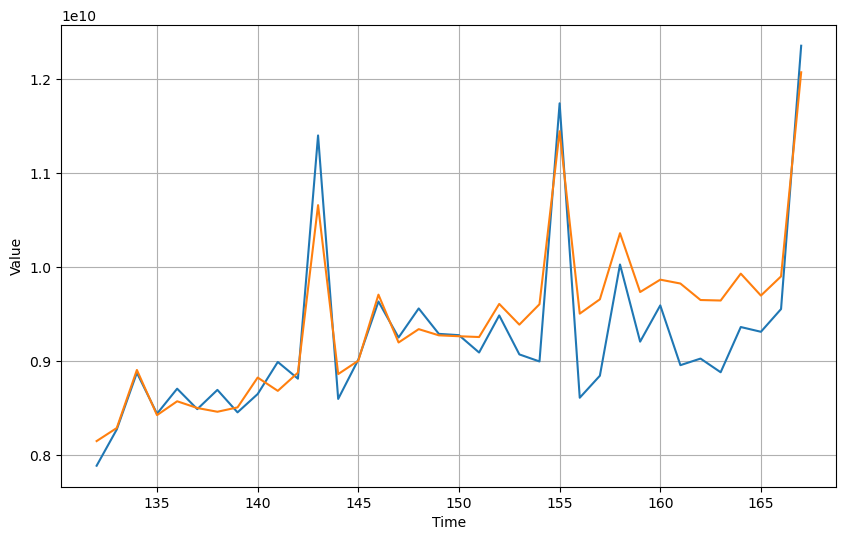

In [240]:
# e*SARIMAX+f*CNN2
cnn_diff_moving_average_test_pred_2 = np.array(e*sarimax_test_pred+f*cnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_diff_moving_average_test_pred_2)

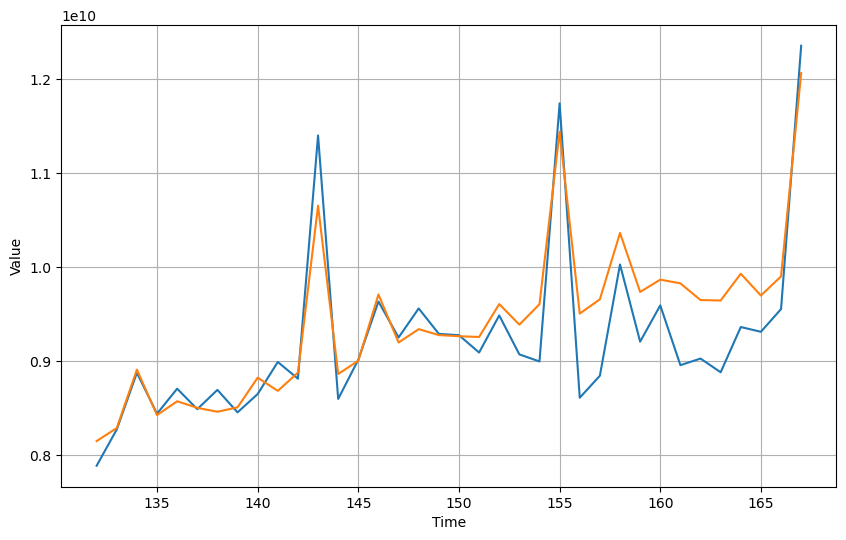

In [241]:
# g*SARIMAX+h*CNN2
cnn_seasonal_trend_test_pred_2 = np.array(g*sarimax_test_pred+h*cnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_seasonal_trend_test_pred_2)

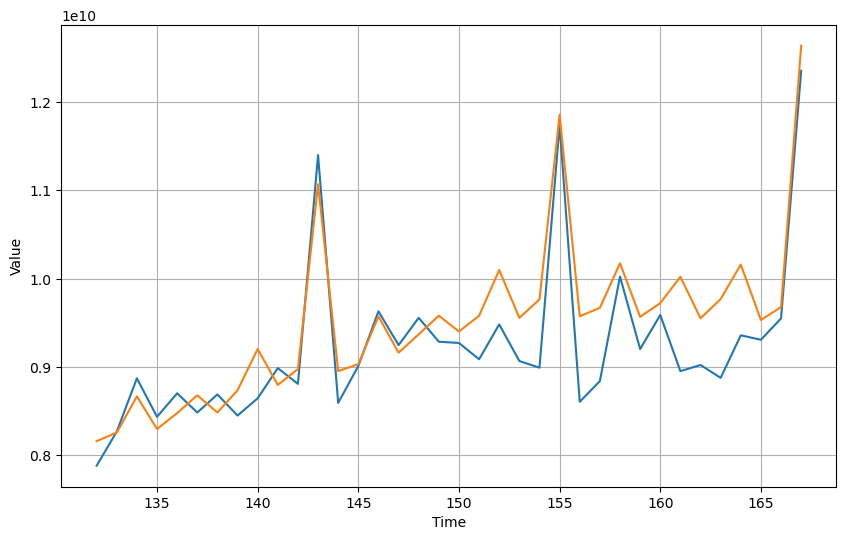

In [243]:
# 単純に12月だけSARIMAX、それ以外をCNN2としてやってみる

# CNN2の12月以外の各値
cnn_test_pred_1_11_2 = cnn_test_pred_2.reshape(3,12)[:, 0:11]

# 1月-11月がCNN2 , 12月がSARIMAX
cnn_1_11_sarimax_12_test_pred_2 =np.ravel(np.append(cnn_test_pred_1_11_2, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_1_11_sarimax_12_test_pred_2)

In [244]:
# MAPE
print('CNN 2 MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred_2))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN 2 SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred_2))
print('CNN 2 SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_deviation_weighted_test_pred_2))
print('CNN 2 SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_diff_moving_average_test_pred_2))
print('CNN 2 SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_seasonal_trend_test_pred_2))
print('CNN 2 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_1_11_sarimax_12_test_pred_2))

CNN 2 MAPE:
0.05440686170966142
SARIMAX MAPE:
0.03675747575470514
CNN 2 SARIMAX Average MAPE:
0.03678098769033453
CNN 2 SARIMAX Deviation weighted MAPE:
0.03299267175183042
CNN 2 SARIMAX Diff Moving Average MAPE:
0.03268124042451237
CNN 2 SARIMAX Seasonal Trend MAPE:
0.03274393299223999
CNN 2 1-11 SARIMAX 12 MAPE:
0.039120483980012215


In [246]:
#  DNN(reluでやり直す)

In [256]:
%%time
# ReLU・エポック数500
# split_by_132/DNN_ReLU_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), input_shape=[window_size], activation='relu'))
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_132', project_name='DNN_ReLU_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.7, 0.9], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 45min 21s, sys: 6min 37s, total: 51min 58s
Wall time: 37min 34s


In [257]:
tuner.results_summary()

Results summary
Results in split_by_132/DNN_ReLU_1
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 22
units2: 18
momentum: 0.9
Score: 4.7108473777771
Trial summary
Hyperparameters:
units1: 30
units2: 22
momentum: 0.7
Score: 4.931832313537598
Trial summary
Hyperparameters:
units1: 18
units2: 10
momentum: 0.9
Score: 5.149232864379883
Trial summary
Hyperparameters:
units1: 22
units2: 22
momentum: 0.7
Score: 5.158132076263428
Trial summary
Hyperparameters:
units1: 22
units2: 26
momentum: 0.5
Score: 5.159389813741048
Trial summary
Hyperparameters:
units1: 14
units2: 26
momentum: 0.7
Score: 5.206164677937825
Trial summary
Hyperparameters:
units1: 26
units2: 10
momentum: 0.9
Score: 5.274275461832683
Trial summary
Hyperparameters:
units1: 30
units2: 26
momentum: 0.5
Score: 5.3081817626953125
Trial summary
Hyperparameters:
units1: 14
units2: 26
momentum: 0.5
Score: 5.375035127003987
Trial summary
Hyperparameters:
units1: 10
units2: 18
momentum: 0.7
Score: 5.383845329284668


In [258]:
%%time
# units1: 22
# units2: 18
# momentum: 0.9

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(22, input_shape=[window_size], activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 104ms/step - loss: 65.9507
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 53.9041
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 32.0290
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 9.9096
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 19.6379
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 16.5231
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 7.5395
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 12.8579
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4982
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 7.5952
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8119
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9109
Epoch 13/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 4.5257
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 4.5254
Epoch 208/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5773
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 4.7248
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 4.5944
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 4.6408
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 4.7389
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 4.5003
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 4.5099
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 4.5171
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 4.4360
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 4.4701
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 3.8999
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 3.8276
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 4.0165
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 4.0790
Epoch 414/500
4/4 [==============================] - 0s 1ms/step - loss: 3.8441
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 3.9294
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 4.0410
Epoch 417/500
4/4 [==============================] - 0s 8ms/step - loss: 3.8227
Epoch 418/500
4/4 [==============================] - 0s 6ms/step - loss: 3.9201
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 3.9393
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 3.9365
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 3.8354
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 15ms/step


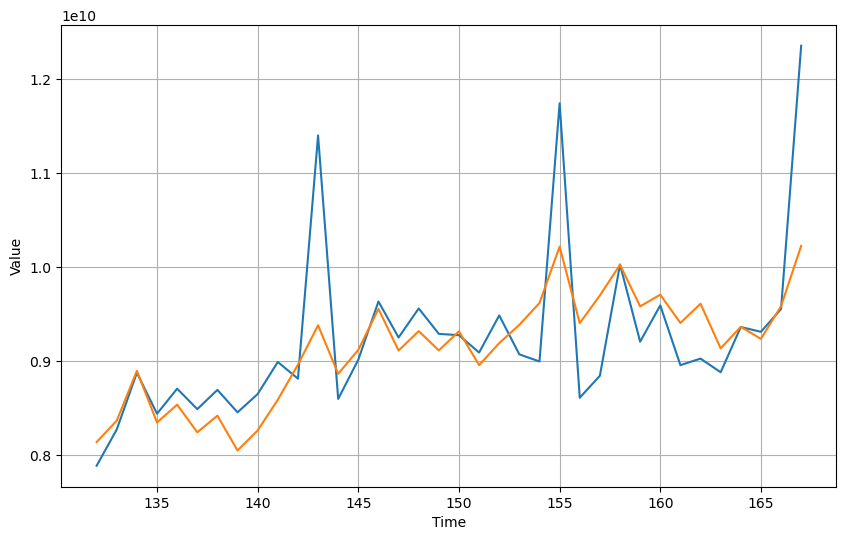

In [259]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [260]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.03979717469009901


In [261]:
dnn_forecast_2 = forecast
dnn_train_pred_2 = train_pred
dnn_test_pred_2 = test_pred

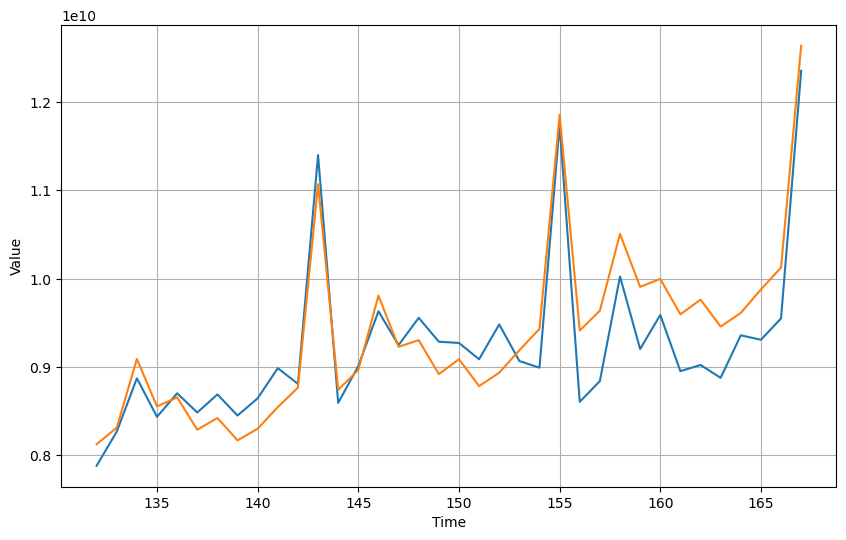

In [262]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

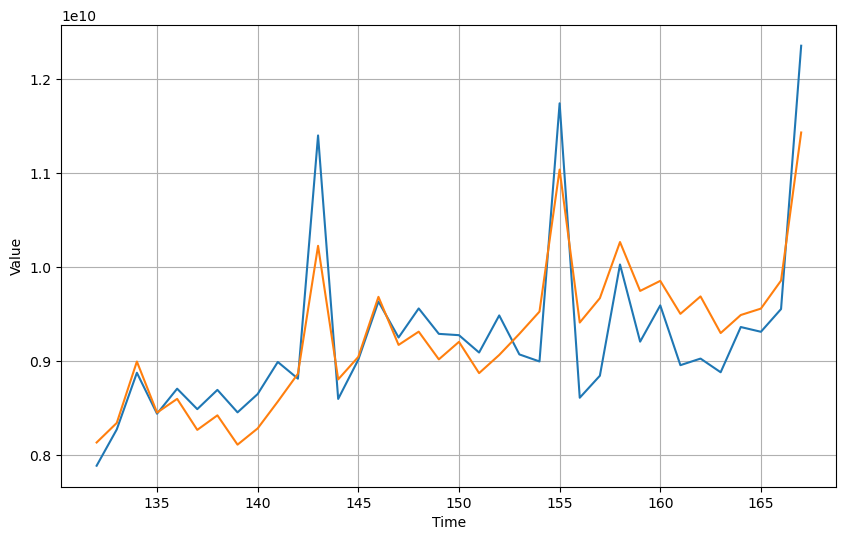

In [263]:
# SARIMAX DNN2 average
dnn_sarimax_2 = np.stack((dnn_test_pred_2, sarimax_test_pred))
dnn_sarimax_ave_test_pred_2 = np.mean(dnn_sarimax_2, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_sarimax_ave_test_pred_2)

In [264]:
# MAPE
print('DNN 2 MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred_2))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN 2 SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred_2))

DNN 2 MAPE:
0.03979717469009901
SARIMAX MAPE:
0.03675747575470514
DNN 2 SARIMAX AVERAGE MAPE:
0.036198566002165034


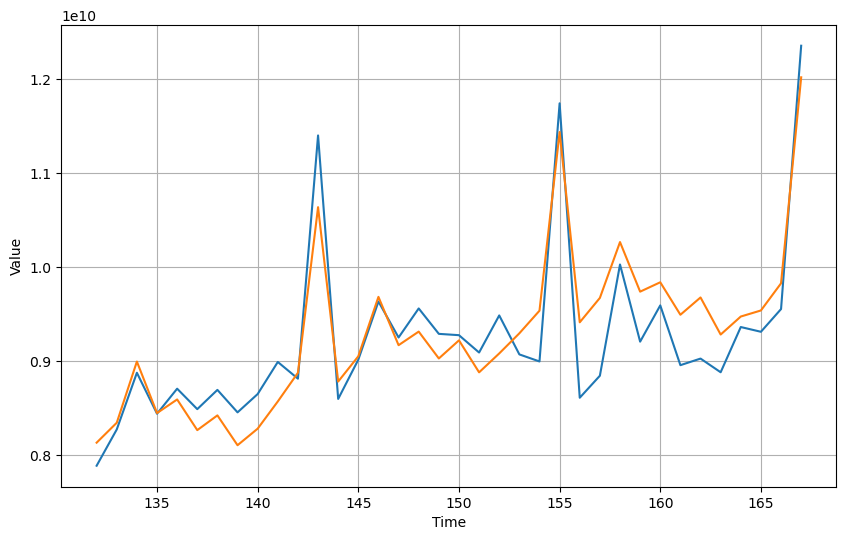

In [265]:
# b*SARIMAX+c*DNN2

dnn_deviation_weighted_test_pred_2 = np.array(b*sarimax_test_pred+c*dnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_deviation_weighted_test_pred_2)

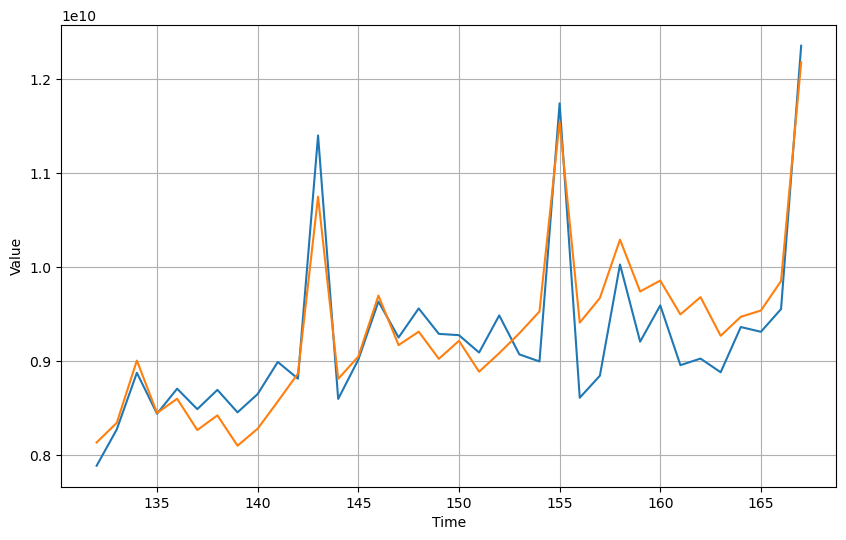

In [266]:
# e*SARIMAX+f*DNN2
dnn_diff_moving_average_test_pred_2 = np.array(e*sarimax_test_pred+f*dnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_diff_moving_average_test_pred_2)

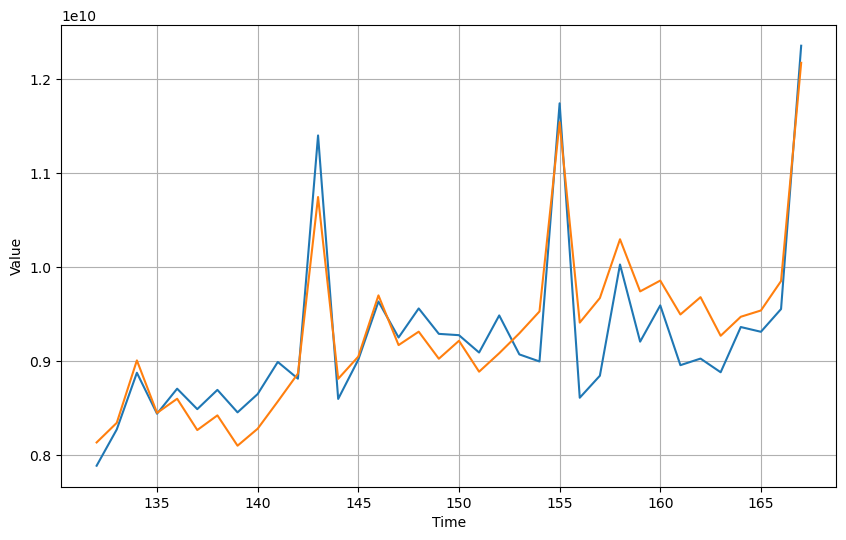

In [267]:
# g*SARIMAX+h*DNN2
dnn_seasonal_trend_test_pred_2 = np.array(g*sarimax_test_pred+h*dnn_test_pred_2)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_seasonal_trend_test_pred_2)

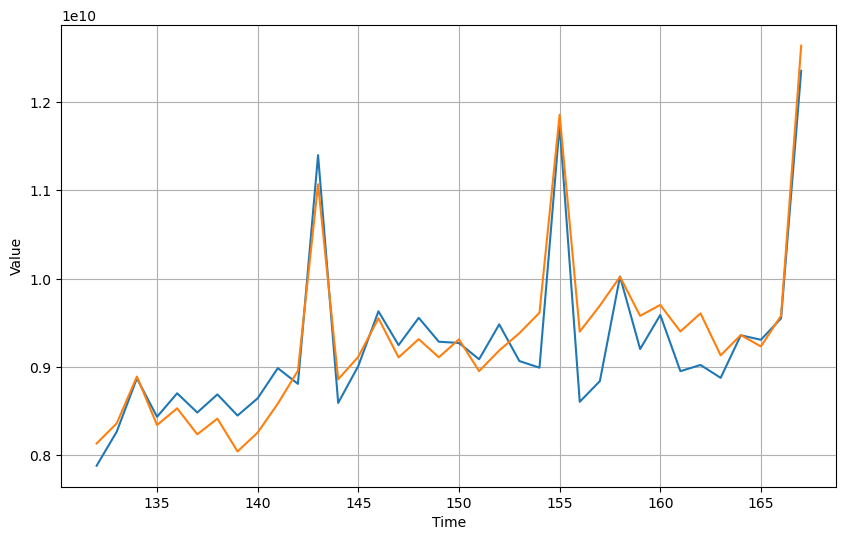

In [268]:
# 単純に12月だけSARIMAX、それ以外をDNN2としてやってみる

# DNN2の12月以外の各値
dnn_test_pred_1_11_2 = dnn_test_pred_2.reshape(3,12)[:, 0:11]

# 1月-11月がDNN2 , 12月がSARIMAX
dnn_1_11_sarimax_12_test_pred_2 =np.ravel(np.append(dnn_test_pred_1_11_2, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_1_11_sarimax_12_test_pred_2)

In [269]:
# MAPE
print('DNN 2 MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred_2))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN 2 SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred_2))
print('DNN 2 SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred_2))
print('DNN 2 SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred_2))
print('DNN 2 SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_seasonal_trend_test_pred_2))
print('DNN 2 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_1_11_sarimax_12_test_pred_2))

DNN 2 MAPE:
0.03979717469009901
SARIMAX MAPE:
0.03675747575470514
DNN 2 SARIMAX Average MAPE:
0.036198566002165034
DNN 2 SARIMAX Deviation weighted MAPE:
0.032495324713071344
DNN 2 SARIMAX Diff Moving Average MAPE:
0.03185721141590629
DNN 2 SARIMAX Seasonal Trend MAPE:
0.03191630198194799
DNN 2 1-11 SARIMAX 12 MAPE:
0.028184220231611847


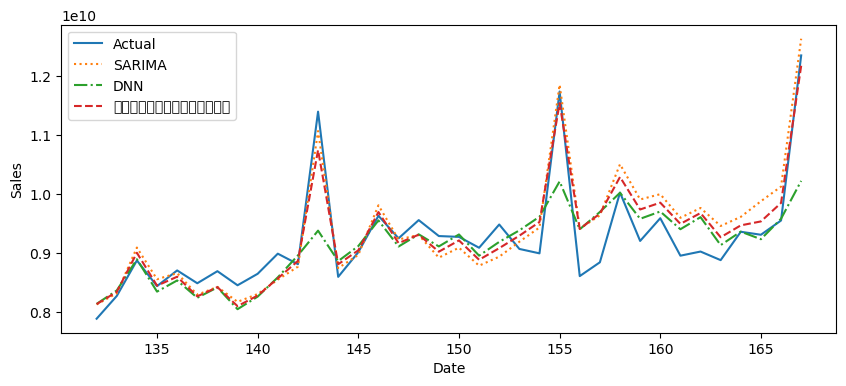

In [303]:
 # https://qiita.com/KntKnk0328/items/5ef40d9e77308dd0d0a4#%E3%83%97%E3%83%AD%E3%83%83%E3%83%88%E3%81%AE%E7%B7%9A%E7%A8%AE%E6%8C%87%E5%AE%9A

plt.figure(figsize=(10, 4))
plt.plot(time_valid, x_valid, label='Actual')
plt.plot(time_valid, sarimax_test_pred,  ':', label='SARIMA')
plt.plot(time_valid, dnn_test_pred_2,  '-.', label='DNN')
plt.plot(time_valid, dnn_diff_moving_average_test_pred_2,  '--', label='移動平均差分加重法　　　　　')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')

In [6]:
import numpy as np
import matplotlib.pyplot as plt

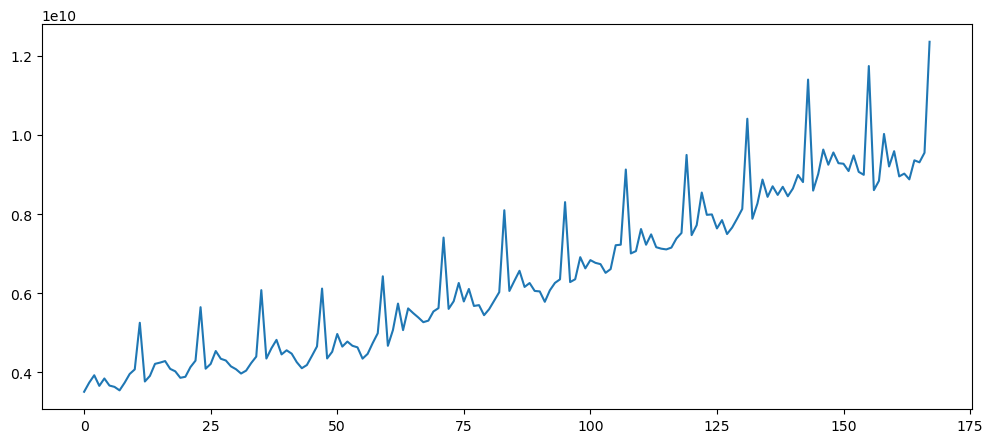

In [11]:
series = np.loadtxt("../public/full_monthly_sales_without_header.csv")
plt.figure(figsize=(12, 5))
plt.plot(series)
plt.show()

Text(0.5, 1.0, 'case1')

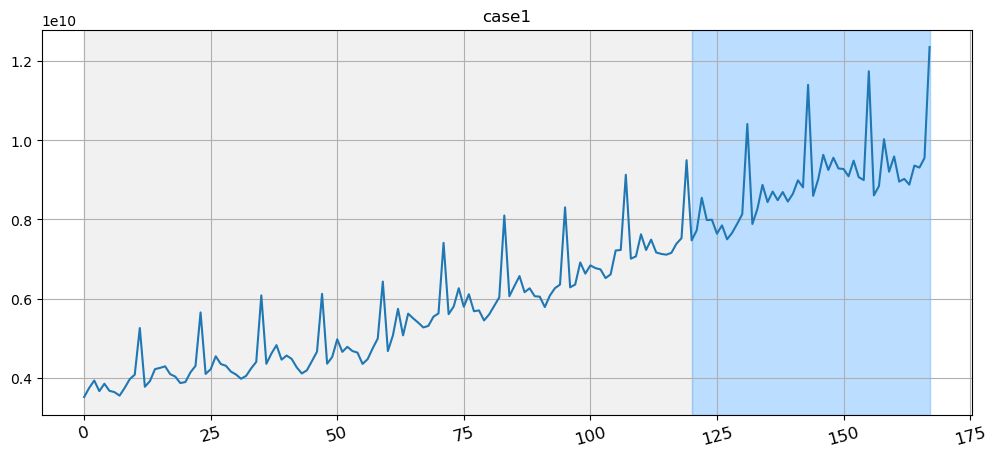

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(series)
ax.axvspan(0, 120, color="lightgray", alpha=0.3)
ax.axvspan(120, 167, color="dodgerblue", alpha=0.3)
ax.grid()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=15, fontsize=12)
ax.set_title("case1")

Text(0.5, 1.0, 'case2')

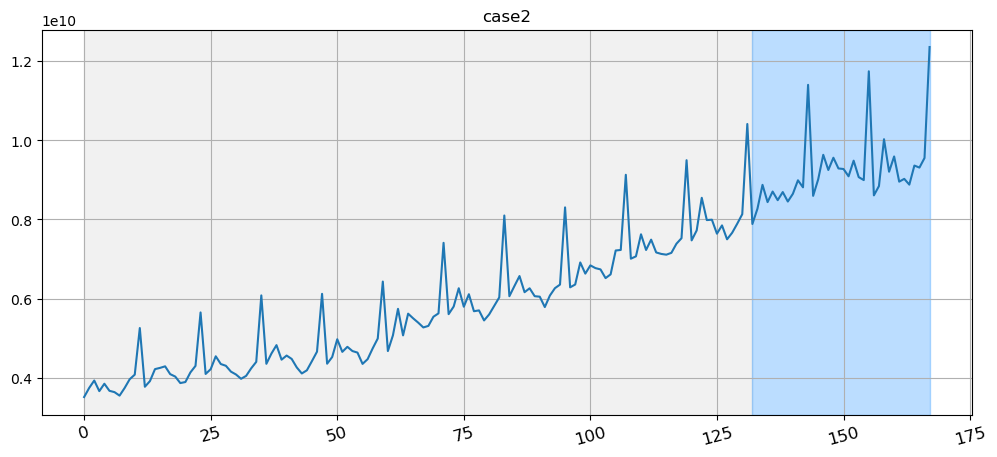

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(series)
ax.axvspan(0, 132, color="lightgray", alpha=0.3)
ax.axvspan(132, 167, color="dodgerblue", alpha=0.3)
ax.grid()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=15, fontsize=12)
ax.set_title("case2")

Text(0.5, 1.0, 'case3')

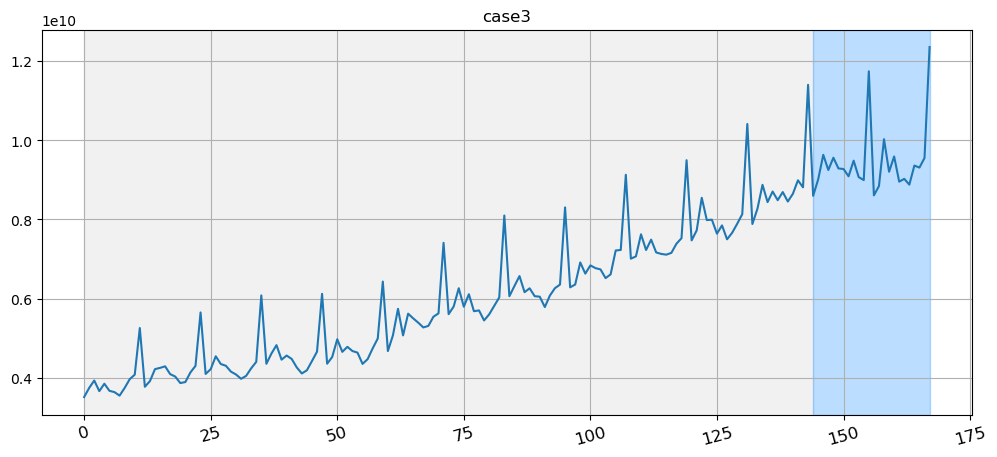

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(series)
ax.axvspan(0, 144, color="lightgray", alpha=0.3)
ax.axvspan(144, 167, color="dodgerblue", alpha=0.3)
ax.grid()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=15, fontsize=12)
ax.set_title("case3")